In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from scipy.stats import norm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

import mlflow

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
import lightgbm
import pickle

In [2]:
df = pd.read_csv('Network_anomaly_data.csv')
df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   duration                125973 non-null  int64  
 1   protocoltype            125973 non-null  object 
 2   service                 125973 non-null  object 
 3   flag                    125973 non-null  object 
 4   srcbytes                125973 non-null  int64  
 5   dstbytes                125973 non-null  int64  
 6   land                    125973 non-null  int64  
 7   wrongfragment           125973 non-null  int64  
 8   urgent                  125973 non-null  int64  
 9   hot                     125973 non-null  int64  
 10  numfailedlogins         125973 non-null  int64  
 11  loggedin                125973 non-null  int64  
 12  numcompromised          125973 non-null  int64  
 13  rootshell               125973 non-null  int64  
 14  suattempted         

In [4]:
df.shape

(125973, 43)

# Data Cleaning

In [5]:
# Checking Null values
df.isnull().sum()

duration                  0
protocoltype              0
service                   0
flag                      0
srcbytes                  0
dstbytes                  0
land                      0
wrongfragment             0
urgent                    0
hot                       0
numfailedlogins           0
loggedin                  0
numcompromised            0
rootshell                 0
suattempted               0
numroot                   0
numfilecreations          0
numshells                 0
numaccessfiles            0
numoutboundcmds           0
ishostlogin               0
isguestlogin              0
count                     0
srvcount                  0
serrorrate                0
srvserrorrate             0
rerrorrate                0
srvrerrorrate             0
samesrvrate               0
diffsrvrate               0
srvdiffhostrate           0
dsthostcount              0
dsthostsrvcount           0
dsthostsamesrvrate        0
dsthostdiffsrvrate        0
dsthostsamesrcportra

There are no missing values in the data.

In [6]:
# checking duplicate value
df.duplicated().sum()

0

## Outlier Detection

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,125973.0,287.144650,2.604515e+03,0.0,0.00,0.00,0.00,4.290800e+04
srcbytes,125973.0,45566.743000,5.870331e+06,0.0,0.00,44.00,276.00,1.379964e+09
dstbytes,125973.0,19779.114421,4.021269e+06,0.0,0.00,0.00,516.00,1.309937e+09
land,125973.0,0.000198,1.408607e-02,0.0,0.00,0.00,0.00,1.000000e+00
wrongfragment,125973.0,0.022687,2.535300e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,125973.0,0.000111,1.436603e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,125973.0,0.204409,2.149968e+00,0.0,0.00,0.00,0.00,7.700000e+01
numfailedlogins,125973.0,0.001222,4.523914e-02,0.0,0.00,0.00,0.00,5.000000e+00
loggedin,125973.0,0.395736,4.890101e-01,0.0,0.00,0.00,1.00,1.000000e+00
numcompromised,125973.0,0.279250,2.394204e+01,0.0,0.00,0.00,0.00,7.479000e+03


<Figure size 2000x4000 with 0 Axes>

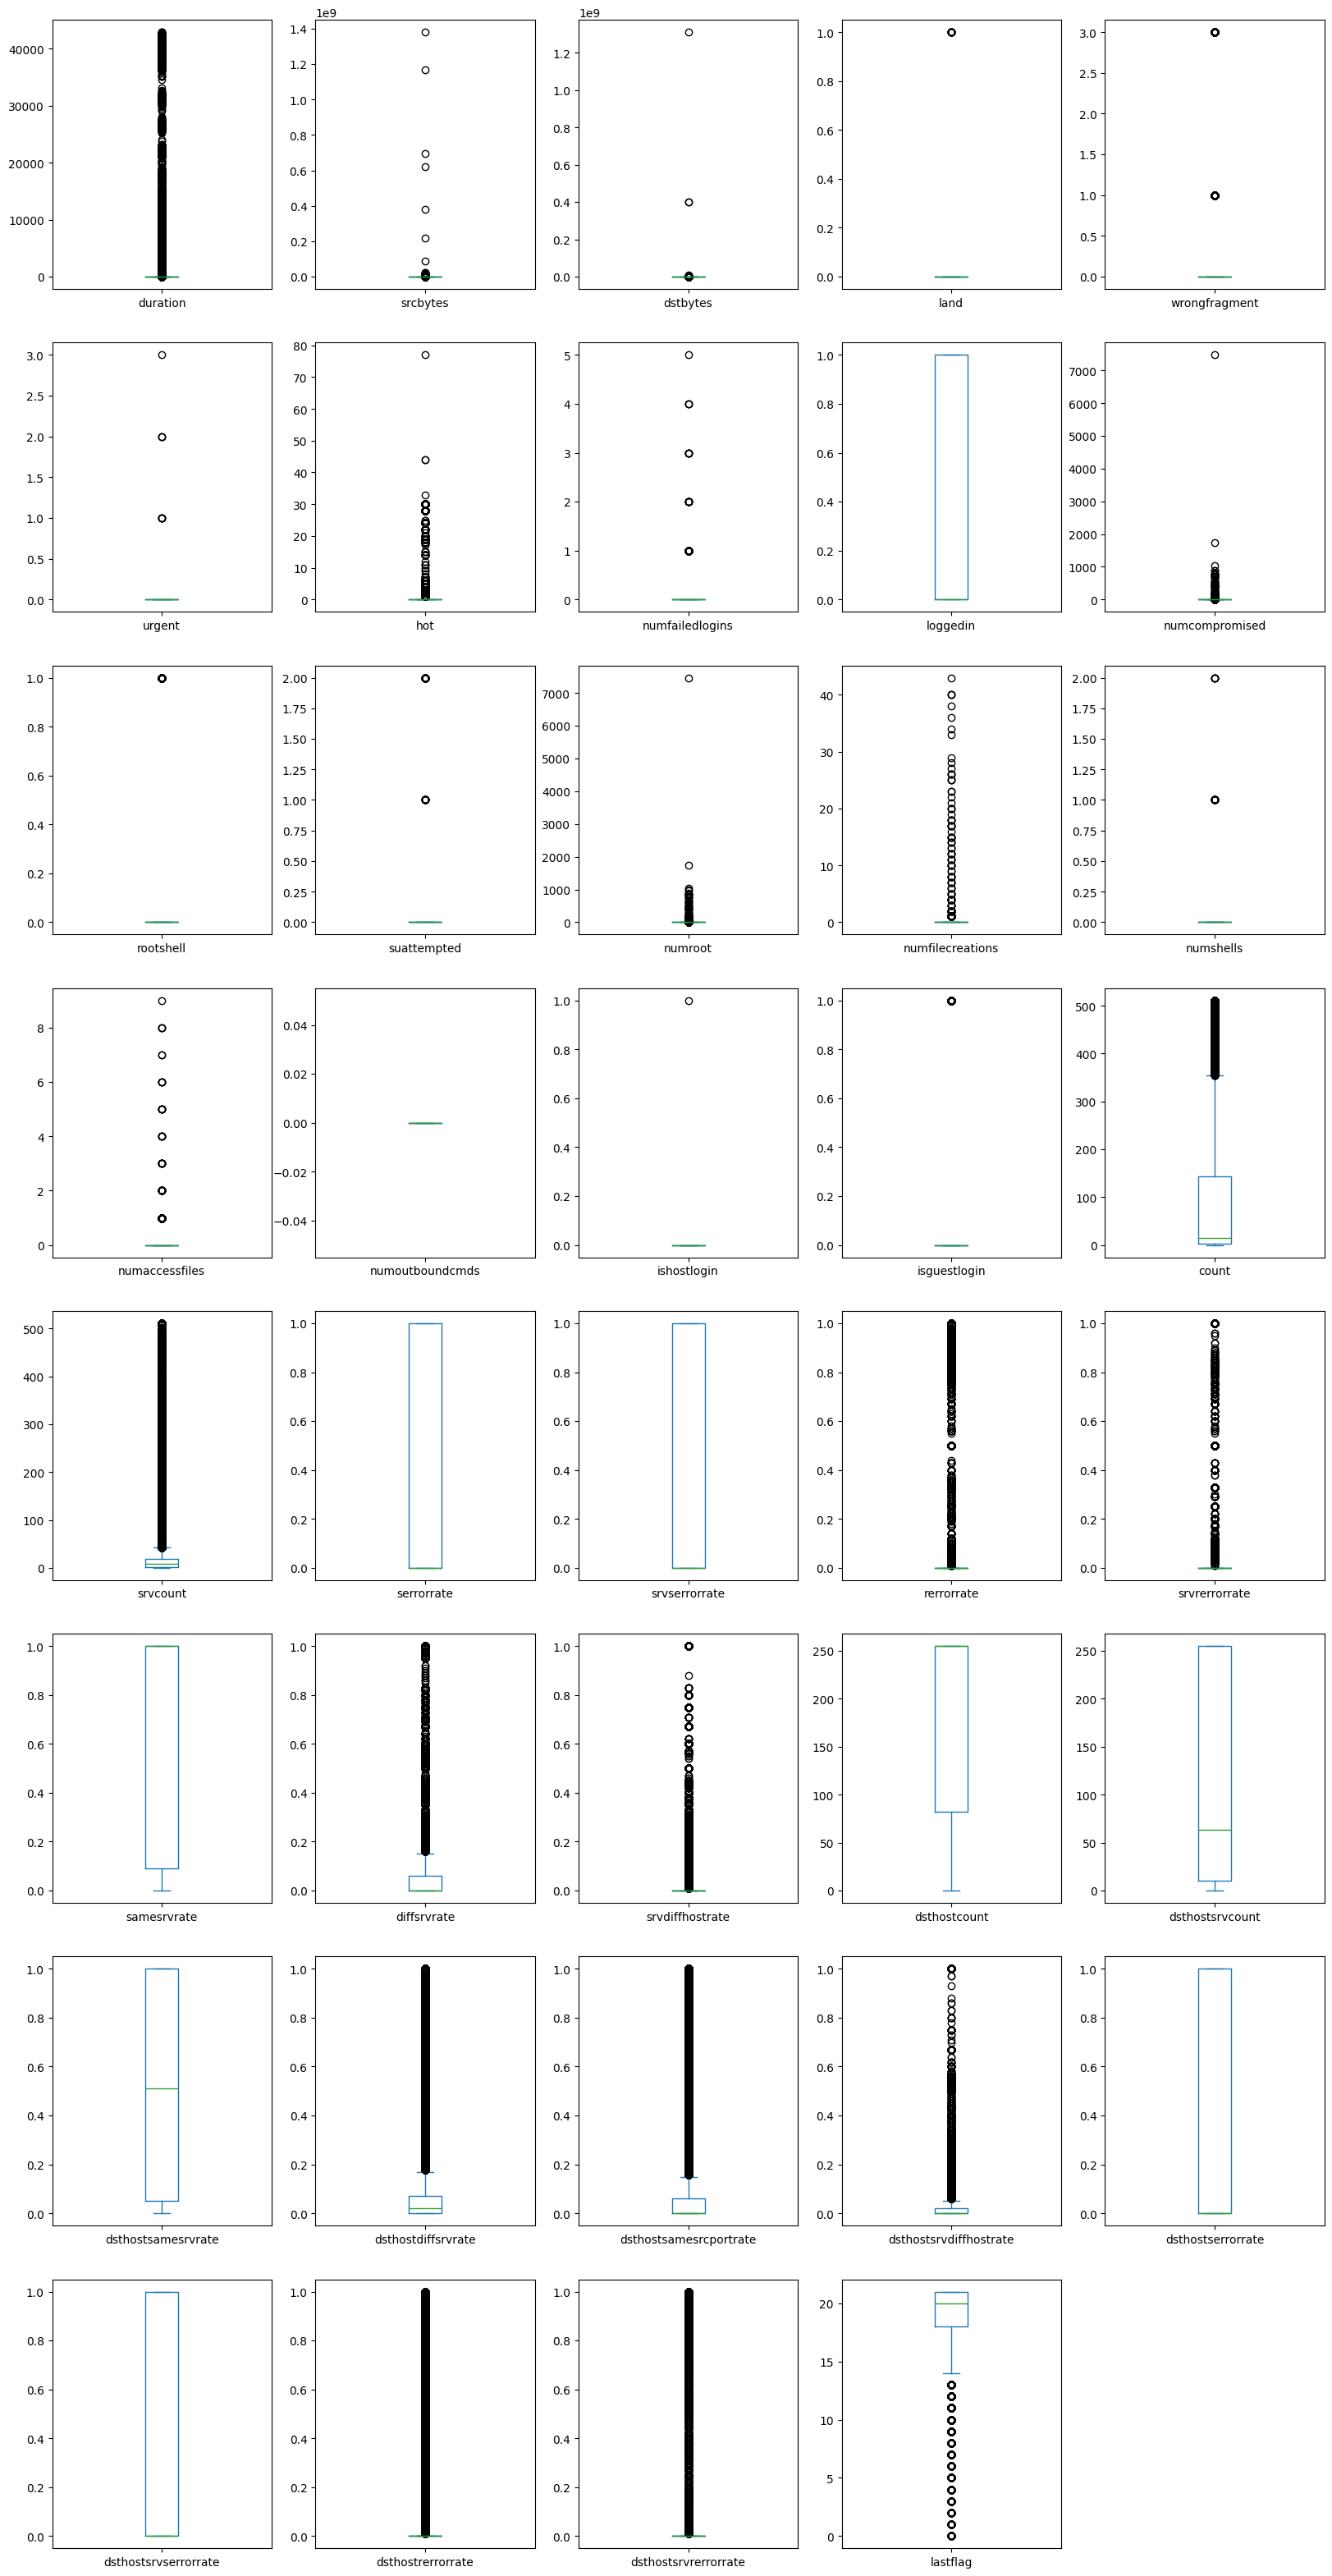

In [8]:
# outlire detection using box plot
plt.figure(figsize=(20,40))
df.plot(kind="box", subplots=True, layout=(8,5), figsize=(20,40))
plt.show()

1. There are outliers present in the data as per the large deviations between the 75% and 100% values in the statistical analysis.
2. As per the box also, outliers are present in the data.
3. However, these outliers consist of important information that help in identifying the type of connection, i.e. attack vs normal and therefore will not be removed from this dataset.

## Feaure Engineering

In [9]:
df.columns

Index(['duration', 'protocoltype', 'service', 'flag', 'srcbytes', 'dstbytes',
       'land', 'wrongfragment', 'urgent', 'hot', 'numfailedlogins', 'loggedin',
       'numcompromised', 'rootshell', 'suattempted', 'numroot',
       'numfilecreations', 'numshells', 'numaccessfiles', 'numoutboundcmds',
       'ishostlogin', 'isguestlogin', 'count', 'srvcount', 'serrorrate',
       'srvserrorrate', 'rerrorrate', 'srvrerrorrate', 'samesrvrate',
       'diffsrvrate', 'srvdiffhostrate', 'dsthostcount', 'dsthostsrvcount',
       'dsthostsamesrvrate', 'dsthostdiffsrvrate', 'dsthostsamesrcportrate',
       'dsthostsrvdiffhostrate', 'dsthostserrorrate', 'dsthostsrvserrorrate',
       'dsthostrerrorrate', 'dsthostsrvrerrorrate', 'attack', 'lastflag'],
      dtype='object')

In [10]:
# type - normal vs attack
def type(x):
    if x == 'normal':
        return 'normal'
    else:
        return 'attack'

In [11]:
df['type'] = df['attack'].apply(type)

In [12]:
df['type'].value_counts()

normal    67343
attack    58630
Name: type, dtype: int64

In [13]:
df['attack'].value_counts()

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: attack, dtype: int64

In [14]:
df['attack'].unique()

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl'], dtype=object)

In [15]:
# Category - DoS, Probe, U2R, R2L
def attack_category(x):
  if x in ['neptune', 'teardrop', 'smurf', 'pod', 'back', 'land']:
    return 'DoS'
  elif x in ['rootkit', 'buffer_overflow', 'multihop', 'loadmodule', 'perl']:
    return 'U2R'
  elif x in ['ipsweep', 'nmap', 'portsweep', 'satan']:
    return 'Probe'
  elif x in ['guess_passwd', 'warezmaster', 'warezclient', 'imap', 'phf', 'spy', 'ftp_write']:
    return 'R2L'
  else:
    return 'normal'

In [16]:
df['attack_category']=df['attack'].apply(attack_category)

In [17]:
df['attack_category'].value_counts()

normal    67343
DoS       45927
Probe     11656
R2L         988
U2R          59
Name: attack_category, dtype: int64

In [18]:
def pie_plot(df, cols_list, rows, cols):
    fig, axes = plt.subplots(rows, cols)
    for ax, col in zip(axes.ravel(), cols_list):
        df[col].value_counts().plot(ax=ax, kind='pie', figsize=(15, 15), fontsize=10, autopct='%1.0f%%')
        ax.set_title(str(col), fontsize = 12)
    plt.show()

In [19]:
df['attack_distribution']=df[df['attack_category']!='normal']['attack_category']

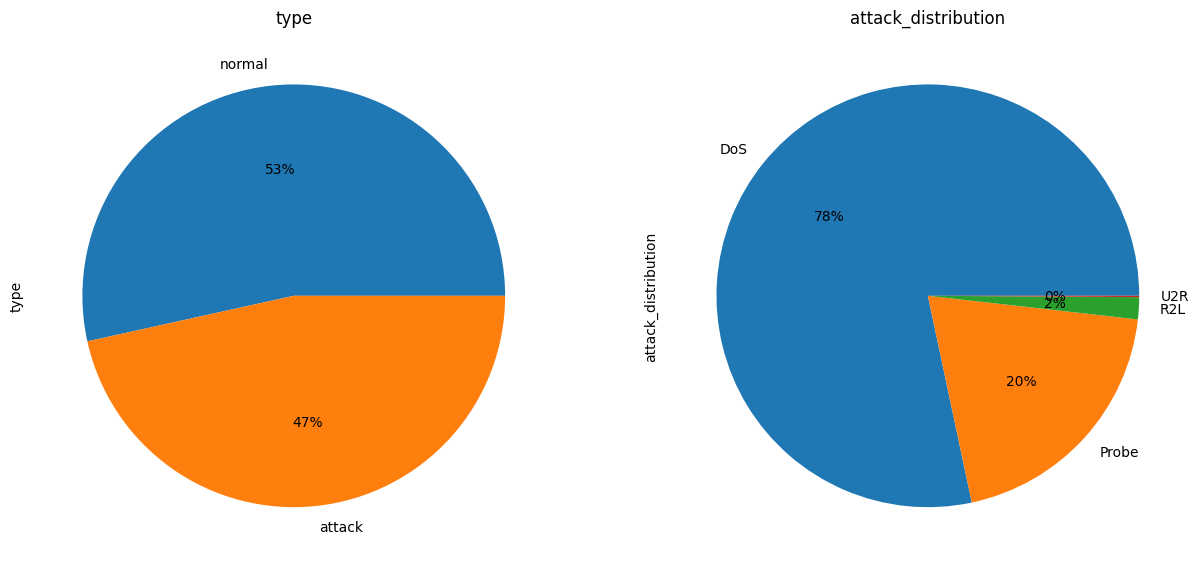

In [20]:
pie_plot(df, ['type', 'attack_distribution'], 1, 2)

Pie Chart Insights

1. The data consists of almost equal distribution of normal vs attack records.
2. DoS followed by Probe are the major attack types present in the dataset.

In [21]:
df.drop(['attack_distribution'], axis=1, inplace=True)

# EDA - Visualization

In [22]:
# Extract Numerical and Categorical Columns
num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

## Univariate Analysis

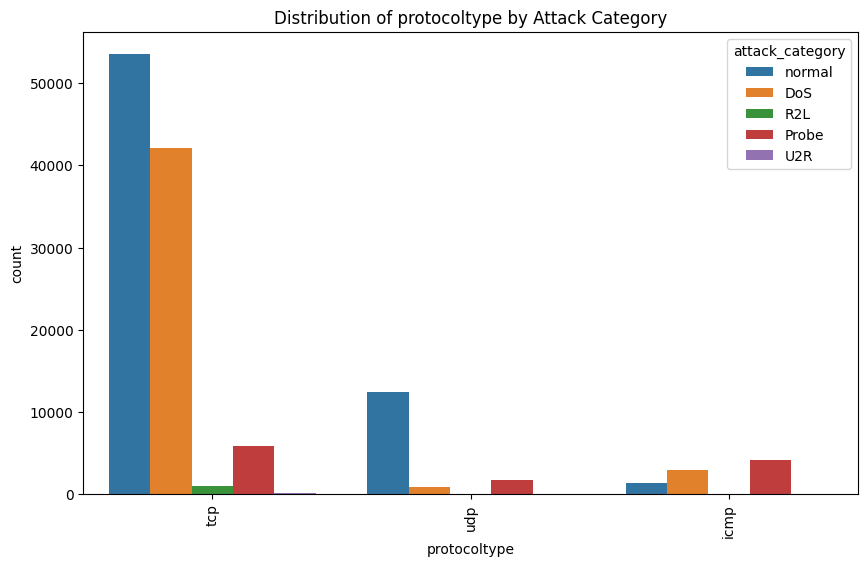

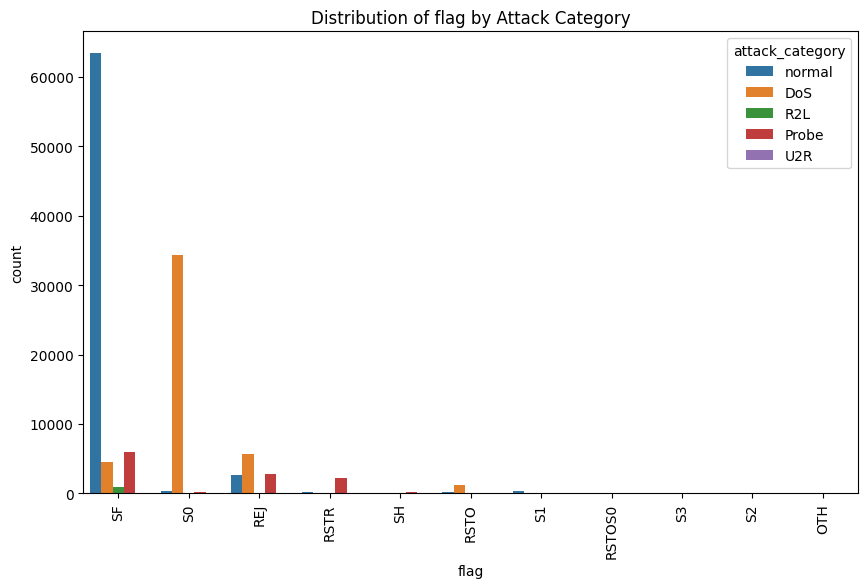

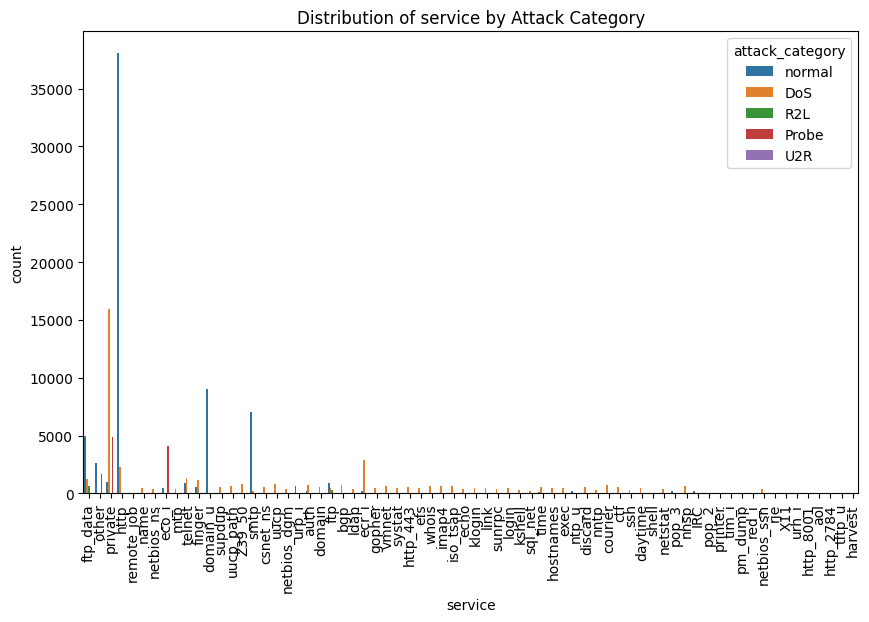

In [23]:
categorical_cols = ['protocoltype', 'flag', 'service']
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue='attack_category', data=df)
    plt.title(f'Distribution of {col} by Attack Category')
    plt.xticks(rotation=90)
    plt.show()

Bar Chart Insights:

1. It can be observed that the most used protocol is tcp and the most used flag and service are SF and http respectively for the normal traffic.
2. It can also be observed that DoS attacks are mainly targeted on private network.

## Bivariate Analysis

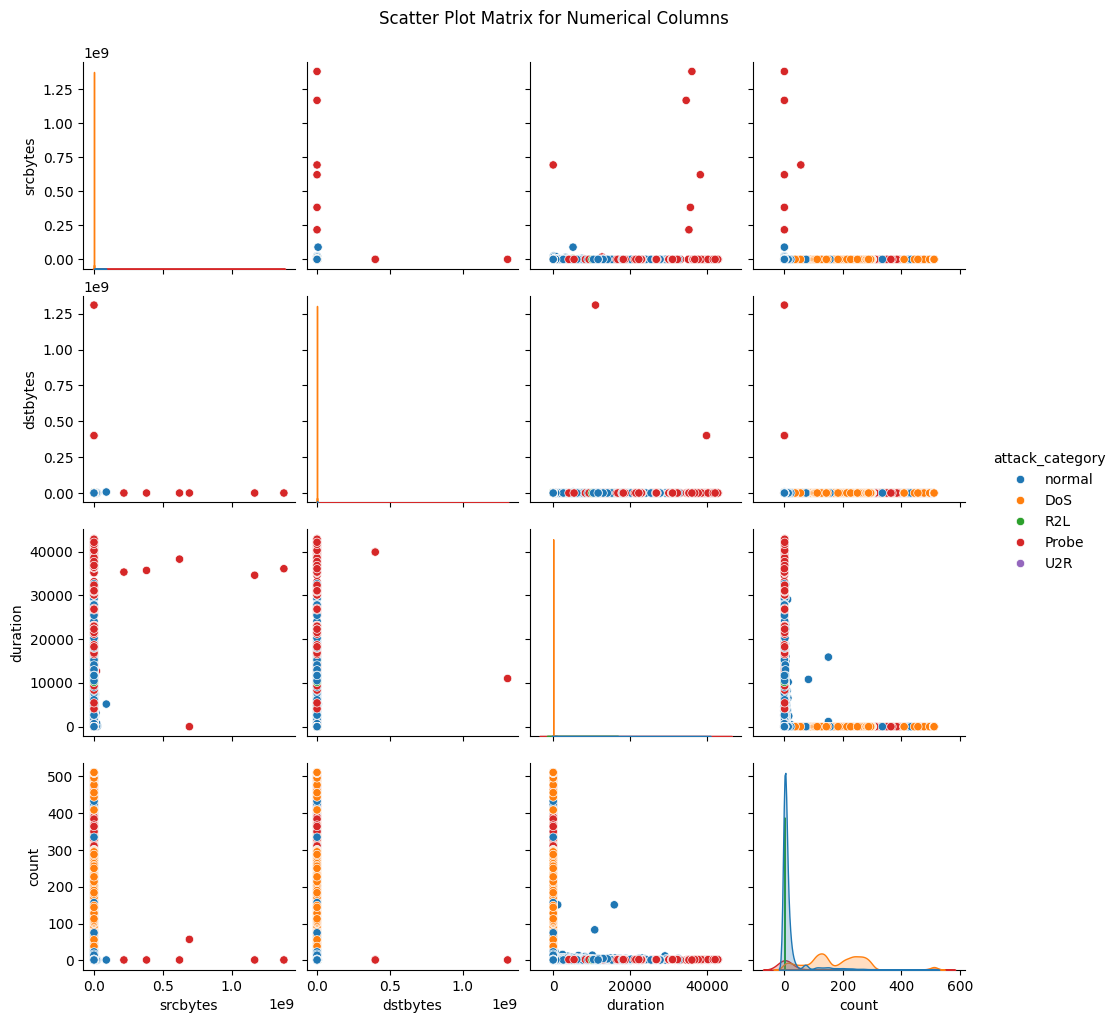

In [24]:
scatter_cols = ['srcbytes', 'dstbytes', 'duration', 'count']

sns.pairplot(df, vars=scatter_cols, hue='attack_category', diag_kind='kde')
plt.suptitle('Scatter Plot Matrix for Numerical Columns', y=1.02)
plt.show()

There seems not much correlation between the features as observed for the scatterplots.

## Multivariate Analysis

## Label Encoding

In [25]:
# Duplicate dataset before label encoding for hypothesis testing
df_hyp = df.copy()

In [26]:
label_mapped = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_mapped[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    

In [27]:
for col, mapping in label_mapped.items():
    print(f"Label encoding mapping for {col}: {mapping}")

Label encoding mapping for protocoltype: {'icmp': 0, 'tcp': 1, 'udp': 2}
Label encoding mapping for service: {'IRC': 0, 'X11': 1, 'Z39_50': 2, 'aol': 3, 'auth': 4, 'bgp': 5, 'courier': 6, 'csnet_ns': 7, 'ctf': 8, 'daytime': 9, 'discard': 10, 'domain': 11, 'domain_u': 12, 'echo': 13, 'eco_i': 14, 'ecr_i': 15, 'efs': 16, 'exec': 17, 'finger': 18, 'ftp': 19, 'ftp_data': 20, 'gopher': 21, 'harvest': 22, 'hostnames': 23, 'http': 24, 'http_2784': 25, 'http_443': 26, 'http_8001': 27, 'imap4': 28, 'iso_tsap': 29, 'klogin': 30, 'kshell': 31, 'ldap': 32, 'link': 33, 'login': 34, 'mtp': 35, 'name': 36, 'netbios_dgm': 37, 'netbios_ns': 38, 'netbios_ssn': 39, 'netstat': 40, 'nnsp': 41, 'nntp': 42, 'ntp_u': 43, 'other': 44, 'pm_dump': 45, 'pop_2': 46, 'pop_3': 47, 'printer': 48, 'private': 49, 'red_i': 50, 'remote_job': 51, 'rje': 52, 'shell': 53, 'smtp': 54, 'sql_net': 55, 'ssh': 56, 'sunrpc': 57, 'supdup': 58, 'systat': 59, 'telnet': 60, 'tftp_u': 61, 'tim_i': 62, 'time': 63, 'urh_i': 64, 'urp_i':

In [28]:
df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag,type,attack_category
0,0,1,20,9,491,0,0,0,0,0,...,0.17,0.00,0.00,0.00,0.05,0.00,11,20,1,4
1,0,2,44,9,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.00,0.00,11,15,1,4
2,0,1,49,5,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,9,19,0,0
3,0,1,24,9,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.00,0.01,11,21,1,4
4,0,1,24,9,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,11,21,1,4


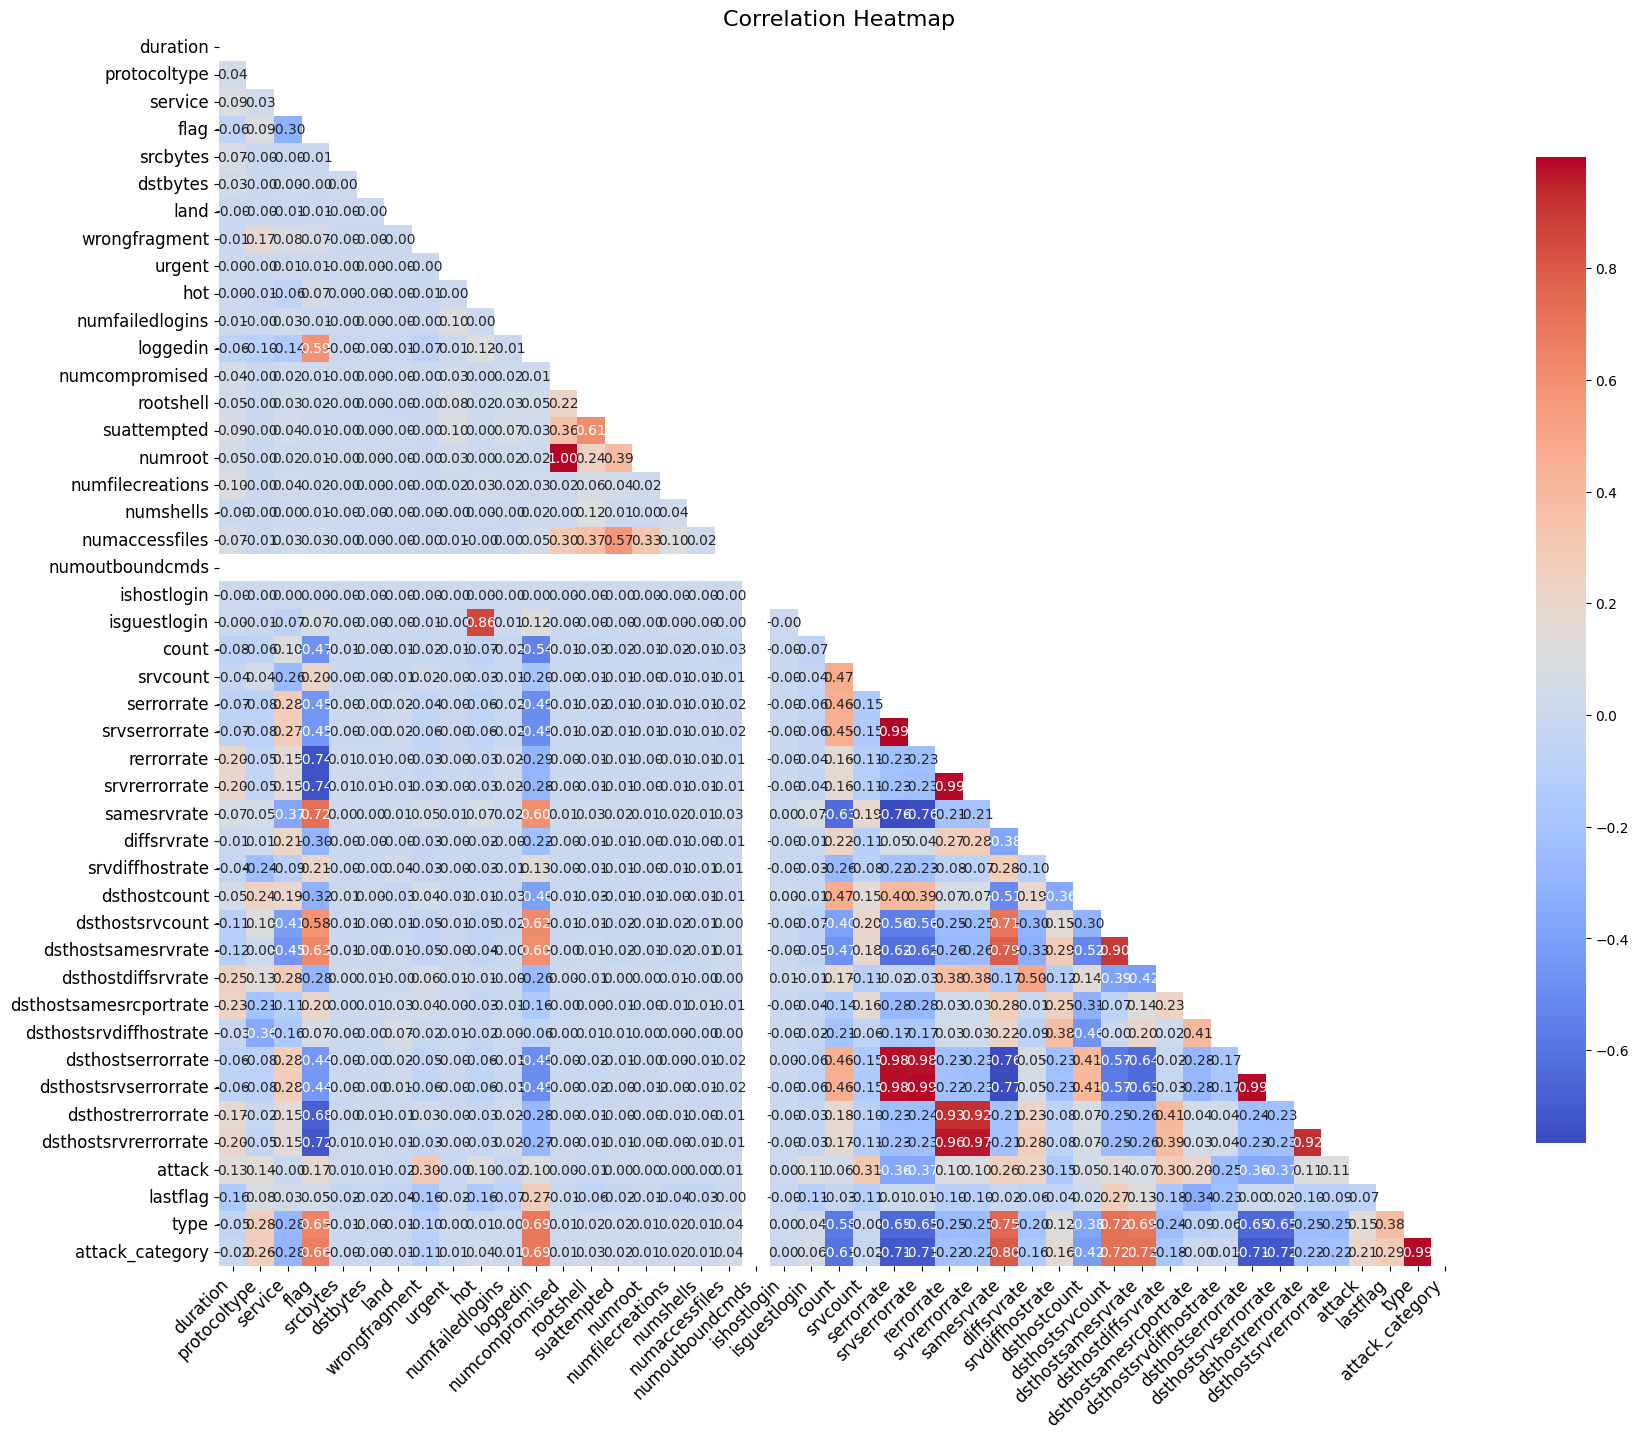

In [29]:
plt.figure(figsize=(20,16))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(), mask=mask ,annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8})
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

In [30]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] >= 0.5)]

df_reduced = df.drop(columns=to_drop)

print(f"Dropped columns: {to_drop}")
print(f"Remaining columns: {df_reduced.columns.tolist()}")

Dropped columns: ['loggedin', 'suattempted', 'numroot', 'numaccessfiles', 'isguestlogin', 'count', 'srvserrorrate', 'rerrorrate', 'srvrerrorrate', 'samesrvrate', 'dsthostcount', 'dsthostsrvcount', 'dsthostsamesrvrate', 'dsthostserrorrate', 'dsthostsrvserrorrate', 'dsthostrerrorrate', 'dsthostsrvrerrorrate', 'type', 'attack_category']
Remaining columns: ['duration', 'protocoltype', 'service', 'flag', 'srcbytes', 'dstbytes', 'land', 'wrongfragment', 'urgent', 'hot', 'numfailedlogins', 'numcompromised', 'rootshell', 'numfilecreations', 'numshells', 'numoutboundcmds', 'ishostlogin', 'srvcount', 'serrorrate', 'diffsrvrate', 'srvdiffhostrate', 'dsthostdiffsrvrate', 'dsthostsamesrcportrate', 'dsthostsrvdiffhostrate', 'attack', 'lastflag']


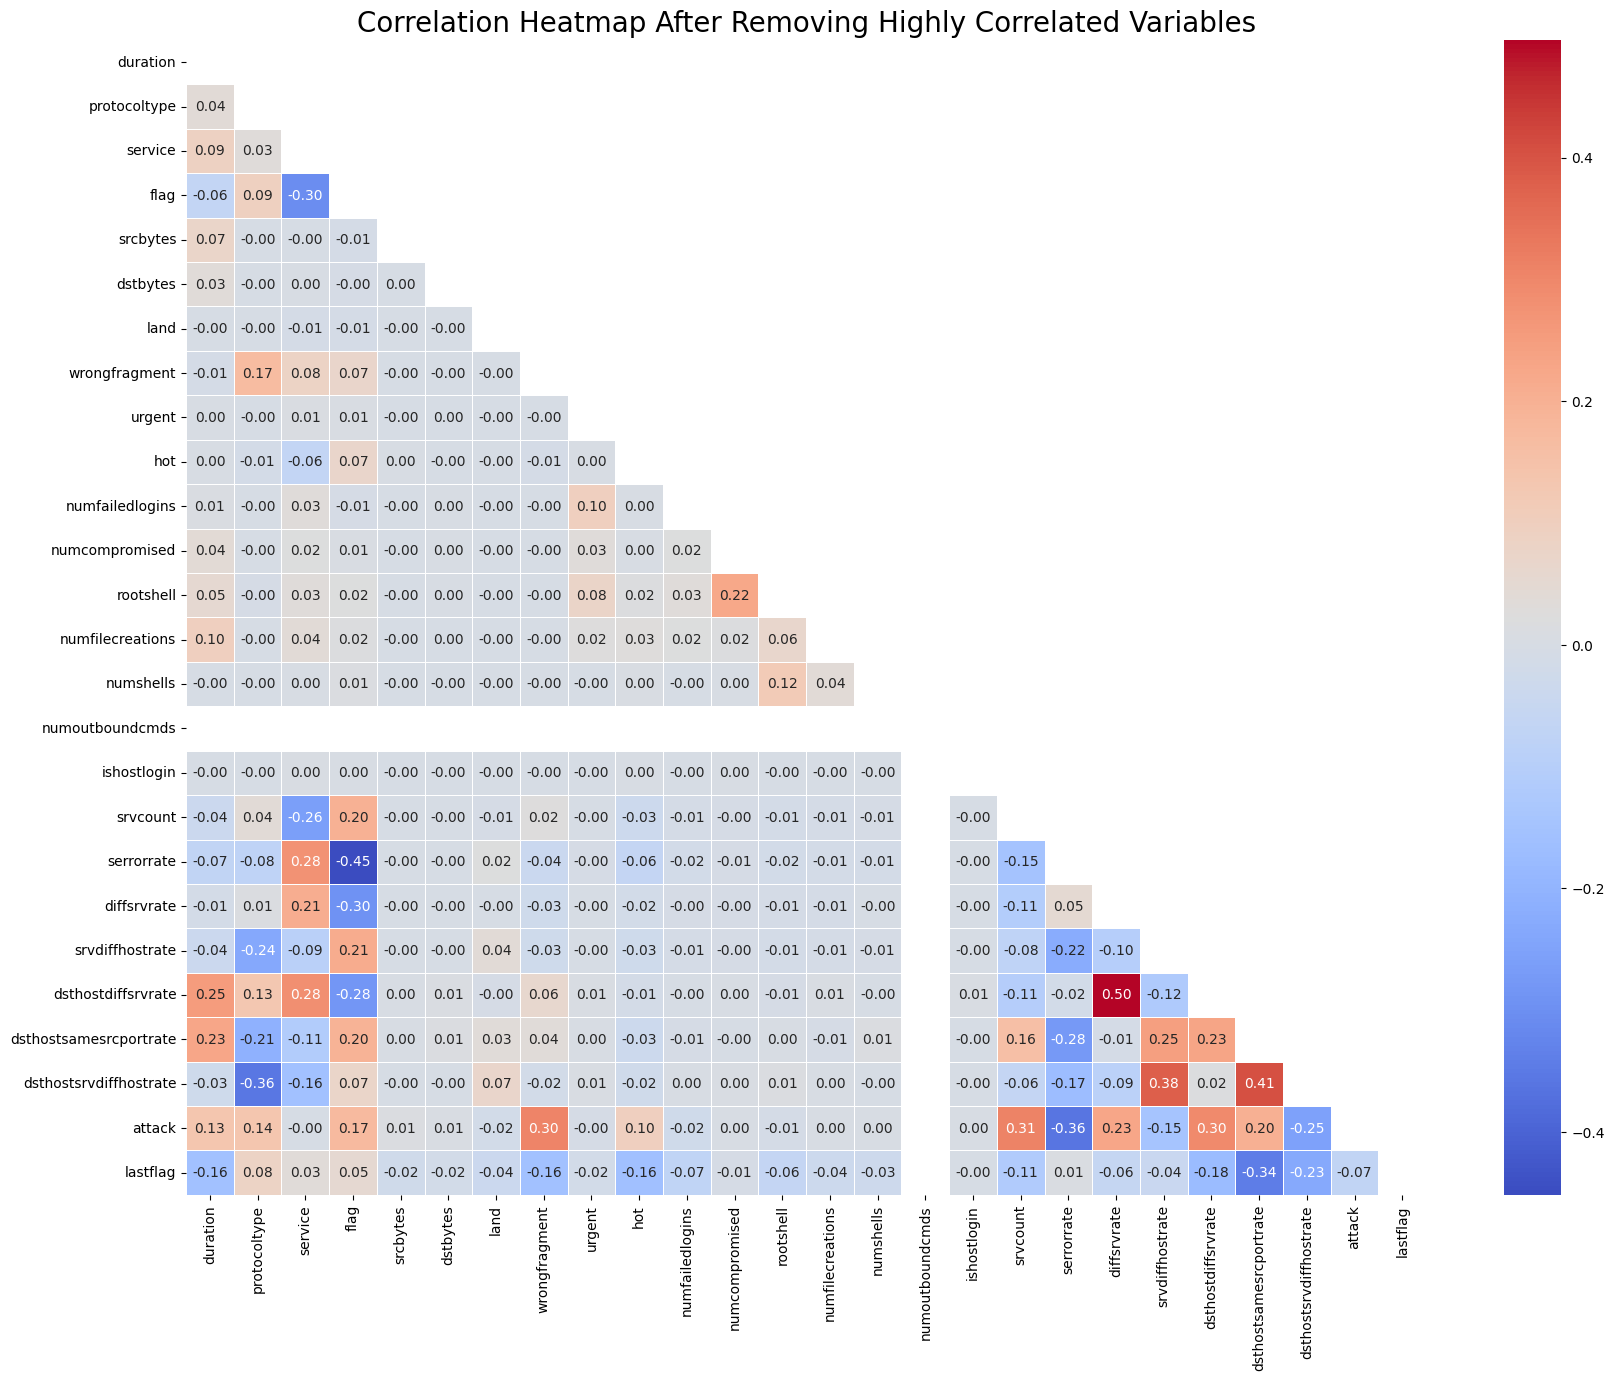

In [31]:
mask_t = np.triu(np.ones_like(df_reduced.corr(), dtype=bool))
plt.figure(figsize=(20, 15))
sns.heatmap(df_reduced.corr(), mask = mask_t, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap After Removing Highly Correlated Variables', size=20)
plt.show()

# Hypothesis Testing

### Network Traffic Volume - Normal vs Attack

In [32]:
normal = df_hyp[df_hyp['type']=='normal']
anomalous = df_hyp[df_hyp['type']!='normal']

In [33]:
# perform t-test
t_src, p_src = stats.ttest_ind(normal['srcbytes'], anomalous['srcbytes'], equal_var=False)
t_dst, p_dst = stats.ttest_ind(normal['dstbytes'], anomalous['dstbytes'], equal_var=False)
print(f"T-test for Src_bytes: t-statistic = {t_src}, p-value = {p_src}")
print(f"T-test for Dst_bytes: t-statistic = {t_dst}, p-value = {p_dst}")

T-test for Src_bytes: t-statistic = -1.9616326188727324, p-value = 0.049809977020307705
T-test for Dst_bytes: t-statistic = -1.3636319854318106, p-value = 0.17268865455671056


In [34]:
alpha = 0.05
if p_src < alpha:
    print("Reject the null hypothesis for Src_bytes: Significant difference in means between normal and anomalous connections.")
else:
    print("Fail to reject the null hypothesis for Src_bytes: No significant difference in means between normal and anomalous connections.")

print()

if p_dst < alpha:
    print("Reject the null hypothesis for Dst_bytes: Significant difference in means between normal and anomalous connections.")
else:
    print("Fail to reject the null hypothesis for Dst_bytes: No significant difference in means between normal and anomalous connections.")

Reject the null hypothesis for Src_bytes: Significant difference in means between normal and anomalous connections.

Fail to reject the null hypothesis for Dst_bytes: No significant difference in means between normal and anomalous connections.


#### Network Traffic Volume - DoS, Probe, R2L, U2R

In [35]:
df_hyp['attack_category'].value_counts()

normal    67343
DoS       45927
Probe     11656
R2L         988
U2R          59
Name: attack_category, dtype: int64

In [36]:
dos = df_hyp[df_hyp['attack_category']=='DoS']
prb = df_hyp[df_hyp['attack_category']=='Probe']
r2l = df_hyp[df_hyp['attack_category']=='R2L']
u2r = df_hyp[df_hyp['attack_category']=='U2R']

In [37]:
anova_src = stats.f_oneway(dos['srcbytes'],prb['srcbytes'],r2l['srcbytes'],u2r['srcbytes'])
anova_dst = stats.f_oneway(dos['dstbytes'],prb['dstbytes'],r2l['dstbytes'],u2r['dstbytes'])

print(f"ANOVA for src_bytes: F-statistic = {anova_src.statistic}, p-value = {anova_src.pvalue}")
print(f"ANOVA for dst_bytes: F-statistic = {anova_dst.statistic}, p-value = {anova_dst.pvalue}")

ANOVA for src_bytes: F-statistic = 6.441909948852057, p-value = 0.00023444768731015726
ANOVA for dst_bytes: F-statistic = 2.9378149665995164, p-value = 0.031885354760832436


In [38]:
alpha = 0.05
if anova_src.pvalue < alpha:
    print("Reject the null hypothesis for src_bytes: Significant difference in means between attack categories.")
else:
    print("Fail to reject the null hypothesis for src_bytes: No significant difference in means between attack categories.")

print()

if anova_dst.pvalue < alpha:
    print("Reject the null hypothesis for dst_bytes: Significant difference in means between attack categories.")
else:
    print("Fail to reject the null hypothesis for dst_bytes: No significant difference in means between attack categories.")

Reject the null hypothesis for src_bytes: Significant difference in means between attack categories.

Reject the null hypothesis for dst_bytes: Significant difference in means between attack categories.


In [39]:
src_bytes_data  = df_hyp[['attack_category', 'srcbytes']]
dst_bytes_data = df_hyp[['attack_category', 'dstbytes']]

tukey_src_bytes = pairwise_tukeyhsd(endog=src_bytes_data['srcbytes'], groups=src_bytes_data['attack_category'], alpha=0.05)
print(tukey_src_bytes)


        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
group1 group2   meandiff   p-adj      lower        upper     reject
-------------------------------------------------------------------
   DoS  Probe  384503.5172    0.0   218454.1254   550552.909   True
   DoS    R2L  308728.1505 0.4743  -206076.3121  823532.6131  False
   DoS    U2R    -325.9822    1.0  -2086025.432 2085373.4676  False
   DoS normal   11956.9582 0.9972   -84932.4126  108846.3289  False
 Probe    R2L  -75775.3667 0.9951  -606278.5029  454727.7695  False
 Probe    U2R -384829.4994 0.9872 -2474459.1646 1704800.1658  False
 Probe normal  -372546.559    0.0  -533162.5389 -211930.5791   True
   R2L    U2R -309054.1327  0.995 -2454748.2796 1836640.0142  False
   R2L normal -296771.1923 0.5117  -809848.8933  216306.5086  False
   U2R normal   12282.9403    1.0 -2072990.9715 2097556.8522  False
-------------------------------------------------------------------


In [40]:
tukey_dst_bytes = pairwise_tukeyhsd(endog=dst_bytes_data['dstbytes'], groups=dst_bytes_data['attack_category'], alpha=0.05)
print(tukey_dst_bytes)

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
group1 group2   meandiff   p-adj      lower        upper     reject
-------------------------------------------------------------------
   DoS  Probe  180905.7103 0.0001      67148.09  294663.3306   True
   DoS    R2L   80723.3106 0.9712    -271960.49  433407.1112  False
   DoS    U2R   29635.8154    1.0 -1399241.4815 1458513.1123  False
   DoS normal    4160.4837 0.9998   -62216.7799   70537.7473  False
 Probe    R2L -100182.3997 0.9441  -463621.0952  263256.2959  False
 Probe    U2R -151269.8949 0.9985 -1582839.7156 1280299.9259  False
 Probe normal -176745.2266 0.0001  -286780.5086  -66709.9446   True
   R2L    U2R  -51087.4952    1.0 -1521066.1409 1418891.1505  False
   R2L normal  -76562.8269  0.976  -428063.6524  274937.9986  False
   U2R normal  -25475.3317    1.0 -1454061.0998 1403110.4363  False
-------------------------------------------------------------------


Summary of Tukey HSD Test Results:

- Significant Differences:
    - **DoS vs. Probe:** There is a significant difference in means between DoS and Probe attack categories for both comparisons (meandiff: 384503.5172 and 180905.7103, p-adj: 0.0 and 0.0001, respectively).
    - **Probe vs. Normal:** There is a significant difference in means between Probe and normal categories for both comparisons (meandiff: -372546.559 and -176745.2266, p-adj: 0.0 and 0.0001, respectively).
- No significant difference in means was found between other attack categories (DoS vs. R2L, DoS vs. U2R, DoS vs. normal, Probe vs. R2L, Probe vs. U2R, R2L vs. U2R, R2L vs. normal, U2R vs. normal) as indicated by high p-adj values (all > 0.05).
This indicates that the means of Src_bytes and Dst_bytes significantly differ between DoS and Probe, and between Probe and normal, suggesting these categories have distinct traffic volume characteristics.

#### Impact of Protocol Type

In [41]:
# Create a contingency table to perform the Chi-square test
contingency_table = pd.crosstab(df_hyp['protocoltype'], df_hyp['attack_category'] != 'normal')
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square Statistic: {chi2}")
print(f"P-value: {p}")

Chi-square Statistic: 10029.24862778463
P-value: 0.0


In [42]:
if p < 0.05:
    print("Reject the null hypothesis: Significant association between protocol type and anomaly detection.")
else:
    print("Fail to reject the null hypothesis: No significant association between protocol type and anomaly detection.")

Reject the null hypothesis: Significant association between protocol type and anomaly detection.


#### Impact of Flag

In [43]:
df_hyp

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag,type,attack_category
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,normal,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,normal,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,attack,DoS
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,normal,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,normal,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20,attack,DoS
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.01,0.00,0.00,0.00,0.00,0.00,normal,21,normal,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.00,0.00,0.72,0.00,0.01,0.00,normal,18,normal,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20,attack,DoS


In [44]:
df_hyp.columns

Index(['duration', 'protocoltype', 'service', 'flag', 'srcbytes', 'dstbytes',
       'land', 'wrongfragment', 'urgent', 'hot', 'numfailedlogins', 'loggedin',
       'numcompromised', 'rootshell', 'suattempted', 'numroot',
       'numfilecreations', 'numshells', 'numaccessfiles', 'numoutboundcmds',
       'ishostlogin', 'isguestlogin', 'count', 'srvcount', 'serrorrate',
       'srvserrorrate', 'rerrorrate', 'srvrerrorrate', 'samesrvrate',
       'diffsrvrate', 'srvdiffhostrate', 'dsthostcount', 'dsthostsrvcount',
       'dsthostsamesrvrate', 'dsthostdiffsrvrate', 'dsthostsamesrcportrate',
       'dsthostsrvdiffhostrate', 'dsthostserrorrate', 'dsthostsrvserrorrate',
       'dsthostrerrorrate', 'dsthostsrvrerrorrate', 'attack', 'lastflag',
       'type', 'attack_category'],
      dtype='object')

In [45]:
df_hyp['is_anomaly'] = np.where(df_hyp['attack_category'] == 'normal', 0, 1)
X = pd.get_dummies(df_hyp['flag'], drop_first=True)
y = df_hyp['is_anomaly']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89     13422
           1       0.93      0.80      0.86     11773

    accuracy                           0.88     25195
   macro avg       0.89      0.88      0.88     25195
weighted avg       0.89      0.88      0.88     25195



In [46]:
# checking coefficient
coefficients = pd.DataFrame(log_reg.coef_.T, index=X.columns, columns=['Coefficient'])
print(coefficients)

        Coefficient
REJ        0.238068
RSTO       0.930731
RSTOS0     2.511567
RSTR       1.809959
S0         3.672208
S1        -4.517865
S2        -3.079077
S3        -2.245095
SF        -2.611657
SH         3.509186


In [47]:
# Interpret the significance
logit_model = sm.Logit(y_train, sm.add_constant(X_train))
result = logit_model.fit()
print(result.summary())

         Current function value: 0.330269
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:             is_anomaly   No. Observations:               100778
Model:                          Logit   Df Residuals:                   100767
Method:                           MLE   Df Model:                           10
Date:                Mon, 13 Jan 2025   Pseudo R-squ.:                  0.5218
Time:                        23:52:16   Log-Likelihood:                -33284.
converged:                      False   LL-Null:                       -69606.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0986      0.365      3.009      0.003       0.383       1.814
REJ            0.0466      0.366      0.127      0.899      -0.67

C:\Users\DEBDUT\anaconda3\envs\ipl\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Summary of Results:
- Classification Report:
    - Overall Accuracy: 88%
    - Precision, Recall, F1-Score:
        - Class 0 (Normal): High precision (0.84), recall (0.95), and F1-score (0.89).
        - Class 1 (Anomalous): High precision (0.93), recall (0.80), and F1-score (0.86).
This indicates that the model is effective at identifying both normal and anomalous connections, though it is slightly better at identifying normal connections.
- Logistic Regression Coefficients:
    - Positive Coefficients: Flags like S0, SH, RSTR have significant positive coefficients, indicating a higher likelihood of anomalies.
    - Negative Coefficients: Flags like S1, S2, S3, SF have significant negative coefficients, indicating a lower likelihood of anomalies.
- Statistical Significance (p-values):
    - Flags such as RSTO, RSTR, S0, S1, S2, S3, SF, and SH have p-values < 0.05, indicating they are significantly associated with anomalies.
    - Flags REJ and RSTOS0 are not significant (p > 0.05).

# Model Building

Data Imbalance using SMOTE

In [48]:
df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag,type,attack_category
0,0,1,20,9,491,0,0,0,0,0,...,0.17,0.00,0.00,0.00,0.05,0.00,11,20,1,4
1,0,2,44,9,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.00,0.00,11,15,1,4
2,0,1,49,5,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,9,19,0,0
3,0,1,24,9,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.00,0.01,11,21,1,4
4,0,1,24,9,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,11,21,1,4


In [49]:
df['attack_category'].value_counts()

4    67343
0    45927
1    11656
2      988
3       59
Name: attack_category, dtype: int64

In [50]:
smote = SMOTE(sampling_strategy={3:150, 2:1000})
X = df.drop(columns=['attack_category', 'attack', 'type'])
y = df['attack_category']

X_resampled, y_resampled = smote.fit_resample(X, y)

df = pd.DataFrame(X_resampled, columns=X.columns)
df['attack_category'] = y_resampled

In [51]:
df['attack_category'].value_counts()

4    67343
0    45927
1    11656
2     1000
3      150
Name: attack_category, dtype: int64

### Standardize the Data

In [52]:
X = df.drop('attack_category', axis=1)
y = df['attack_category']

In [53]:
X.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag
0,0,1,20,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20
1,0,2,44,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15
2,0,1,49,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19
3,0,1,24,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21
4,0,1,24,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21


In [54]:
col = X.columns
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=col)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

## Supervised Learning

In [56]:
labels = le.classes_

In [57]:
mlflow.set_experiment('Network Anomaly Detection')

<Experiment: artifact_location='file:///D:/Scaler/Data_Analysis_Projects/Network-Anomaly-Detection/mlruns/271346979261190921', creation_time=1736680921301, experiment_id='271346979261190921', last_update_time=1736680921301, lifecycle_stage='active', name='Network Anomaly Detection', tags={}>

#### SVC

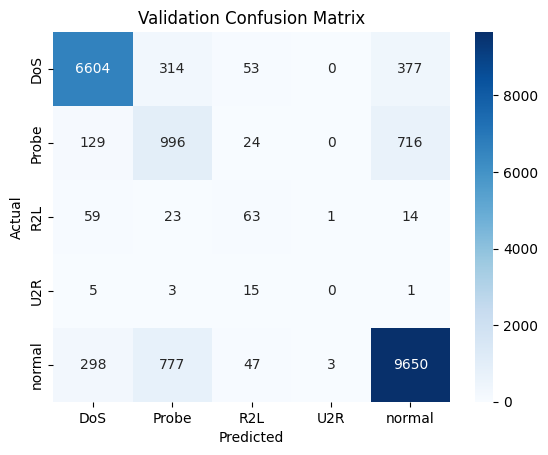

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.91      7348
           1       0.47      0.53      0.50      1865
           2       0.31      0.39      0.35       160
           3       0.00      0.00      0.00        24
           4       0.90      0.90      0.90     10775

    accuracy                           0.86     20172
   macro avg       0.52      0.54      0.53     20172
weighted avg       0.86      0.86      0.86     20172



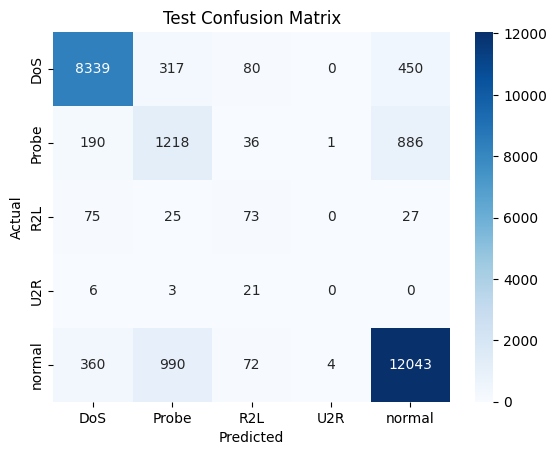

Test Classification Report:
               precision    recall  f1-score   support

         DoS       0.93      0.91      0.92      9186
       Probe       0.48      0.52      0.50      2331
         R2L       0.26      0.36      0.30       200
         U2R       0.00      0.00      0.00        30
      normal       0.90      0.89      0.90     13469

    accuracy                           0.86     25216
   macro avg       0.51      0.54      0.52     25216
weighted avg       0.86      0.86      0.86     25216



In [58]:
with mlflow.start_run():
    svm = SVC(kernel='sigmoid', random_state=42)
    svm.fit(X_train, y_train)

    y_pred_val = svm.predict(X_val)

    mlflow.set_tag('mlflow.runName', 'svm_sig')

    val_acc = accuracy_score(y_val, y_pred_val)
    mlflow.log_metric("val_accuracy", val_acc)

    # confution metrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Validation Confusion Matrix')
    plt.savefig('val_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('val_confusion_matrix.png')

    # classification report
    classification_report_val = classification_report(y_val, y_pred_val)
    print('Validation Classification Report:\n', classification_report_val)

    with open('val_classification_report.txt', 'w') as f:
        f.write(classification_report_val)
    mlflow.log_artifact('val_classification_report.txt')

    # prediction for the test data
    y_pred = svm.predict(X_test)

    # Accuracy
    test_acc = accuracy_score(y_test, y_pred)
    mlflow.log_metric("test_accuracy", test_acc)

    # confusion metrix
    cm_test = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test Confusion Matrix')
    plt.savefig('test_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('test_confusion_matrix.png')

    # Classification Report
    y_test_transform = le.inverse_transform(y_test)
    y_pred_transform = le.inverse_transform(y_pred)
    classification_report_test = classification_report(y_test_transform, y_pred_transform)
    print('Test Classification Report:\n', classification_report_test)

    # with open('test_classification_report.txt', 'w') as f:
    #     f.write(classification_report_test)
    # mlflow.log_artifact('test_classification_report.txt')
    
    # mlflow.log_param("kernel", "sigmoid")

    # mlflow.sklearn.log_model(svm, "model")

#### RandomForest Classification

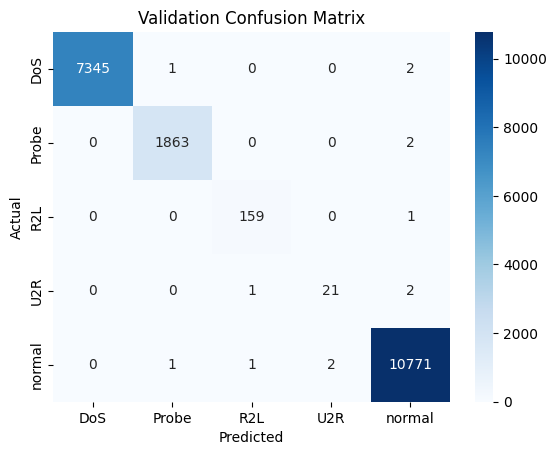

Validation Classification Report:
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      7348
       Probe       1.00      1.00      1.00      1865
         R2L       0.99      0.99      0.99       160
         U2R       0.91      0.88      0.89        24
      normal       1.00      1.00      1.00     10775

    accuracy                           1.00     20172
   macro avg       0.98      0.97      0.98     20172
weighted avg       1.00      1.00      1.00     20172



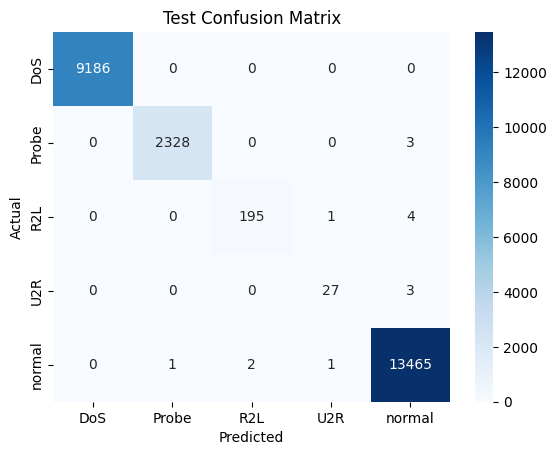

Test Classification Report:
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      9186
       Probe       1.00      1.00      1.00      2331
         R2L       0.99      0.97      0.98       200
         U2R       0.93      0.90      0.92        30
      normal       1.00      1.00      1.00     13469

    accuracy                           1.00     25216
   macro avg       0.98      0.97      0.98     25216
weighted avg       1.00      1.00      1.00     25216



2025/01/14 00:00:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [59]:
with mlflow.start_run():
    rfc = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
    rfc.fit(X_train, y_train)

    y_pred_val = rfc.predict(X_val)

    mlflow.set_tag('mlflow.runName', 'rf_200_d20')

    # Accuracy
    val_acc = accuracy_score(y_val, y_pred_val)
    mlflow.log_metric("val_accuracy", val_acc)

    # Confusion Matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Validation Confusion Matrix')
    plt.savefig('val_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('val_confusion_matrix.png')

    # Classification Report
    y_val_transform = le.inverse_transform(y_val)
    y_pred_val_transform = le.inverse_transform(y_pred_val)
    classification_report_val = classification_report(y_val_transform, y_pred_val_transform)
    print('Validation Classification Report:\n', classification_report_val)
    
    with open('val_classification_report.txt', 'w') as f:
        f.write(classification_report_val)
    mlflow.log_artifact('val_classification_report.txt')

    # For Test Data Prediction
    y_pred = rfc.predict(X_test)
    
    # Accuracy
    test_acc = accuracy_score(y_test, y_pred)
    mlflow.log_metric("test_accuracy", test_acc)
    
    # Confusion Matrix
    cm_test = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test Confusion Matrix')
    plt.savefig('test_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('test_confusion_matrix.png')

    # Classification Report
    y_test_transform = le.inverse_transform(y_test)
    y_pred_transform = le.inverse_transform(y_pred)
    classification_report_test = classification_report(y_test_transform, y_pred_transform)
    print('Test Classification Report:\n', classification_report_test)
    
    with open('test_classification_report.txt', 'w') as f:
        f.write(classification_report_test)
    mlflow.log_artifact('test_classification_report.txt')
    
    # Log model
    mlflow.sklearn.log_model(rfc, "model")

    # Log parameters
    mlflow.log_param("n_estimators", rfc.n_estimators)
    mlflow.log_param("max_depth", rfc.max_depth)
    mlflow.log_param("random_state", rfc.random_state)

### Feature Importance

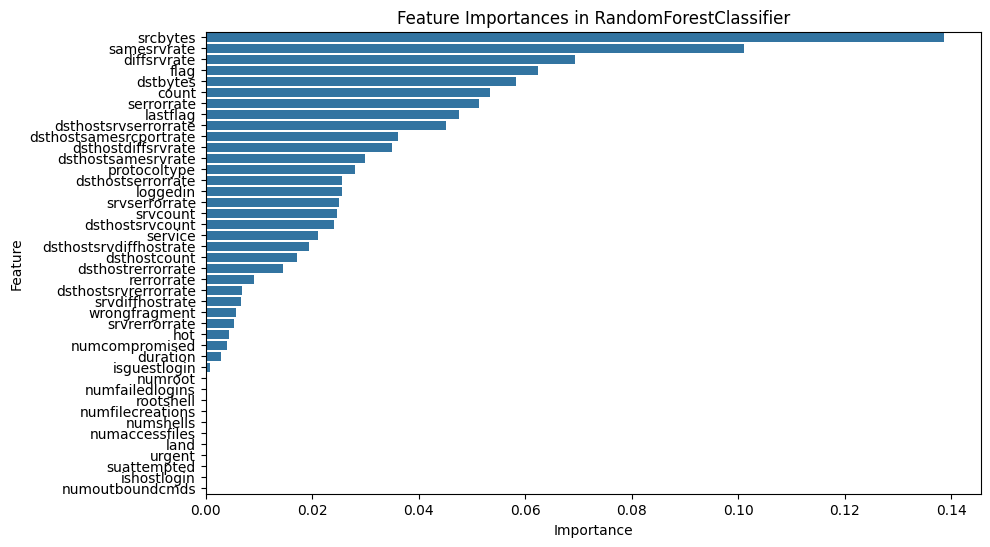

In [60]:
# implementinf Features importance
feature_importances = rfc.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances in RandomForestClassifier')
plt.show()

#### Feature Reduction

In [61]:

df_red = feature_importance_df[feature_importance_df['Importance']<=0.015]
df_red.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 39 to 19
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Feature     21 non-null     object 
 1   Importance  21 non-null     float64
dtypes: float64(1), object(1)
memory usage: 504.0+ bytes


In [62]:
cols = df_red['Feature'].tolist()
cols

['dsthostrerrorrate',
 'rerrorrate',
 'dsthostsrvrerrorrate',
 'srvdiffhostrate',
 'wrongfragment',
 'srvrerrorrate',
 'hot',
 'numcompromised',
 'duration',
 'isguestlogin',
 'numroot',
 'numfailedlogins',
 'rootshell',
 'numfilecreations',
 'numshells',
 'numaccessfiles',
 'land',
 'urgent',
 'suattempted',
 'ishostlogin',
 'numoutboundcmds']

In [63]:
X_train_red = X_train.drop(cols, axis=1)
X_val_red = X_val.drop(cols, axis=1)
X_test_red = X_test.drop(cols, axis=1)

In [64]:
X_train_red.columns

Index(['protocoltype', 'service', 'flag', 'srcbytes', 'dstbytes', 'loggedin',
       'count', 'srvcount', 'serrorrate', 'srvserrorrate', 'samesrvrate',
       'diffsrvrate', 'dsthostcount', 'dsthostsrvcount', 'dsthostsamesrvrate',
       'dsthostdiffsrvrate', 'dsthostsamesrcportrate',
       'dsthostsrvdiffhostrate', 'dsthostserrorrate', 'dsthostsrvserrorrate',
       'lastflag'],
      dtype='object')

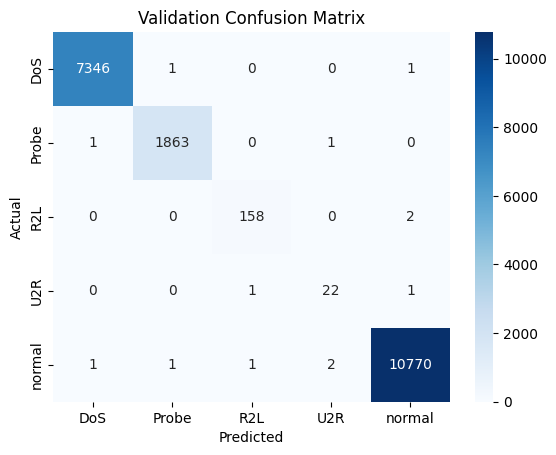

Validation Classification Report:
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      7348
       Probe       1.00      1.00      1.00      1865
         R2L       0.99      0.99      0.99       160
         U2R       0.88      0.92      0.90        24
      normal       1.00      1.00      1.00     10775

    accuracy                           1.00     20172
   macro avg       0.97      0.98      0.98     20172
weighted avg       1.00      1.00      1.00     20172



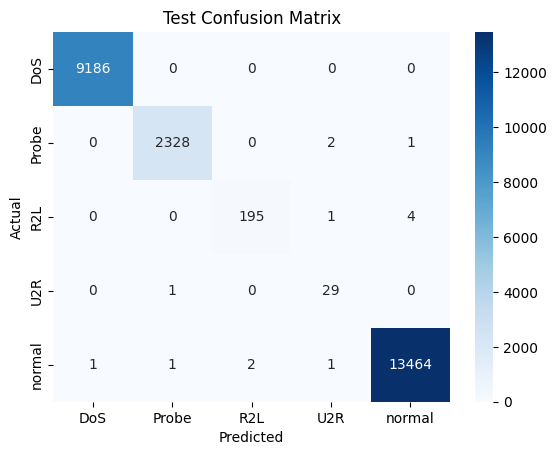

Test Classification Report:
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      9186
       Probe       1.00      1.00      1.00      2331
         R2L       0.99      0.97      0.98       200
         U2R       0.88      0.97      0.92        30
      normal       1.00      1.00      1.00     13469

    accuracy                           1.00     25216
   macro avg       0.97      0.99      0.98     25216
weighted avg       1.00      1.00      1.00     25216



2025/01/14 00:01:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [65]:
with mlflow.start_run():
    # Train the model
    rfc = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
    rfc.fit(X_train_red, y_train)

    # set tag
    mlflow.set_tag('mlflow.runName', 'rf_red_200_d20_red21')

    # validation data prediction
    y_pred_val = rfc.predict(X_val_red)

    # Accuracy
    val_acc = accuracy_score(y_val, y_pred_val)
    mlflow.log_metric("val_accuracy", val_acc)

    # Confusion Matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Validation Confusion Matrix')
    plt.savefig('val_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('val_confusion_matrix.png')

    # Classification Report
    y_val_transform = le.inverse_transform(y_val)
    y_pred_val_transform = le.inverse_transform(y_pred_val)
    classification_report_val = classification_report(y_val_transform, y_pred_val_transform)
    print('Validation Classification Report:\n', classification_report_val)
    
    with open('val_classification_report.txt', 'w') as f:
        f.write(classification_report_val)
    mlflow.log_artifact('val_classification_report.txt')

    # Test Data Prediction
    y_pred = rfc.predict(X_test_red)

    # Accuracy
    test_acc = accuracy_score(y_test, y_pred)
    mlflow.log_metric("test_accuracy", test_acc)

    # Confusion Matrix
    cm_test = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test Confusion Matrix')
    plt.savefig('test_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('test_confusion_matrix.png')
    
    # Classification Report
    y_test_transform = le.inverse_transform(y_test)
    y_pred_transform = le.inverse_transform(y_pred)
    classification_report_test = classification_report(y_test_transform, y_pred_transform)
    print('Test Classification Report:\n', classification_report_test)
    
    with open('test_classification_report.txt', 'w') as f:
        f.write(classification_report_test)
    mlflow.log_artifact('test_classification_report.txt')
    
    # Log model
    mlflow.sklearn.log_model(rfc, "model")

    # Log parameters
    mlflow.log_param("n_estimators", rfc.n_estimators)
    mlflow.log_param("max_depth", rfc.max_depth)
    mlflow.log_param("random_state", rfc.random_state)

### GBDT

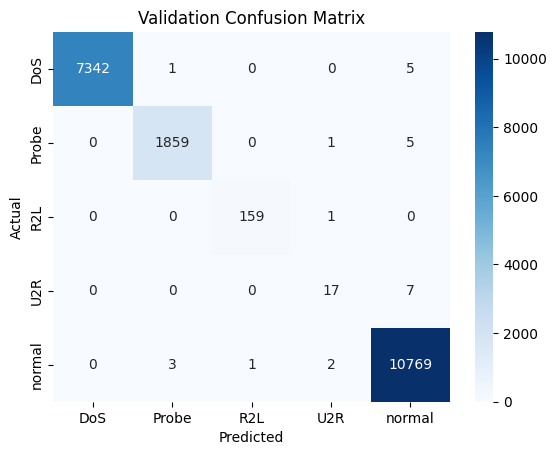

Validation Classification Report:
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      7348
       Probe       1.00      1.00      1.00      1865
         R2L       0.99      0.99      0.99       160
         U2R       0.81      0.71      0.76        24
      normal       1.00      1.00      1.00     10775

    accuracy                           1.00     20172
   macro avg       0.96      0.94      0.95     20172
weighted avg       1.00      1.00      1.00     20172



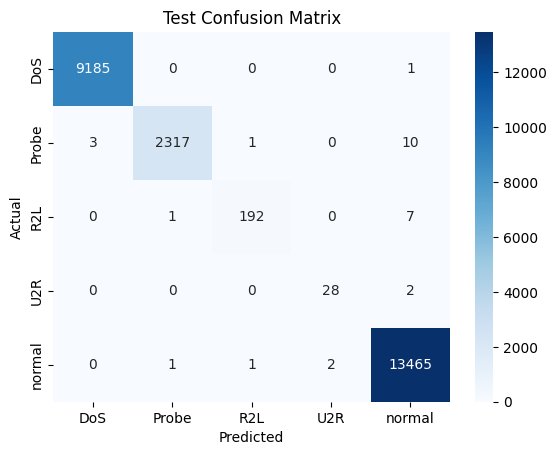

Test Classification Report:
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      9186
       Probe       1.00      0.99      1.00      2331
         R2L       0.99      0.96      0.97       200
         U2R       0.93      0.93      0.93        30
      normal       1.00      1.00      1.00     13469

    accuracy                           1.00     25216
   macro avg       0.98      0.98      0.98     25216
weighted avg       1.00      1.00      1.00     25216



2025/01/14 00:05:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [66]:
with mlflow.start_run():
    gbt = GradientBoostingClassifier(n_estimators=50, max_depth=20, learning_rate=0.05, random_state=42)
    gbt.fit(X_train, y_train)

    # Validation Data Prediction
    y_pred_val = gbt.predict(X_val)

    mlflow.set_tag('mlflow.runName', 'gbdt_50_d20_l0.05')

    # Accuracy
    val_acc = accuracy_score(y_val, y_pred_val)
    mlflow.log_metric("val_accuracy", val_acc)

    # Confusion Matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Validation Confusion Matrix')
    plt.savefig('val_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('val_confusion_matrix.png')
    
    # Classification Report
    y_val_transform = le.inverse_transform(y_val)
    y_pred_val_transform = le.inverse_transform(y_pred_val)
    classification_report_val = classification_report(y_val_transform, y_pred_val_transform)
    print('Validation Classification Report:\n', classification_report_val)
    
    with open('val_classification_report.txt', 'w') as f:
        f.write(classification_report_val)
    mlflow.log_artifact('val_classification_report.txt')
    
    # Test Data
    # Prediction
    y_pred = gbt.predict(X_test)
    
    # Accuracy
    test_acc = accuracy_score(y_test, y_pred)
    mlflow.log_metric("test_accuracy", test_acc)
    
    # Confusion Matrix
    cm_test = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test Confusion Matrix')
    plt.savefig('test_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('test_confusion_matrix.png')
    
    # Classification Report
    y_test_transform = le.inverse_transform(y_test)
    y_pred_transform = le.inverse_transform(y_pred)
    classification_report_test = classification_report(y_test_transform, y_pred_transform)
    print('Test Classification Report:\n', classification_report_test)
    
    with open('test_classification_report.txt', 'w') as f:
        f.write(classification_report_test)
    mlflow.log_artifact('test_classification_report.txt')
    
    # Log model
    mlflow.sklearn.log_model(gbt, "model")

    # Log parameters
    mlflow.log_param("n_estimators", gbt.n_estimators)
    mlflow.log_param("max_depth", gbt.max_depth)
    mlflow.log_param("random_state", gbt.random_state)

### XGBoost

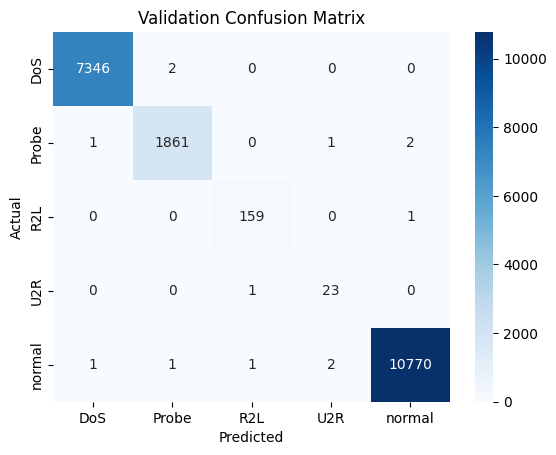

Validation Classification Report:
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      7348
       Probe       1.00      1.00      1.00      1865
         R2L       0.99      0.99      0.99       160
         U2R       0.88      0.96      0.92        24
      normal       1.00      1.00      1.00     10775

    accuracy                           1.00     20172
   macro avg       0.97      0.99      0.98     20172
weighted avg       1.00      1.00      1.00     20172



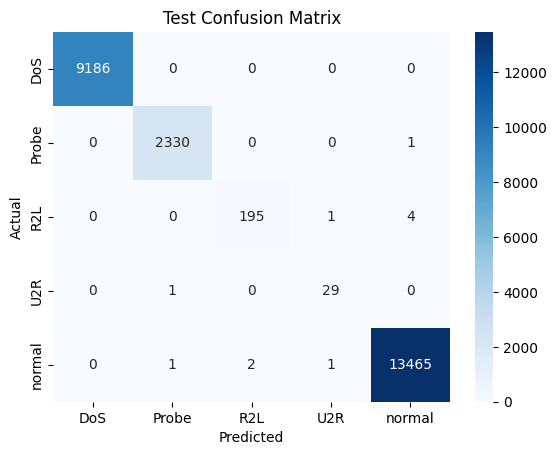

Test Classification Report:
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      9186
       Probe       1.00      1.00      1.00      2331
         R2L       0.99      0.97      0.98       200
         U2R       0.94      0.97      0.95        30
      normal       1.00      1.00      1.00     13469

    accuracy                           1.00     25216
   macro avg       0.98      0.99      0.99     25216
weighted avg       1.00      1.00      1.00     25216



2025/01/14 00:05:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [67]:
with mlflow.start_run():
    # Train the model
    xgb = XGBClassifier(n_estimators=250, max_depth=20, learning_rate=0.07, random_state=42)
    xgb.fit(X_train, y_train)
    
    # set tag
    mlflow.set_tag('mlflow.runName', 'xgb_n250_d20_l.07')
        
    # Validation Data
    # Prediction
    y_pred_val = xgb.predict(X_val)
    
    # Accuracy
    val_acc = accuracy_score(y_val, y_pred_val)
    mlflow.log_metric("val_accuracy", val_acc)
    
    # Confusion Matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Validation Confusion Matrix')
    plt.savefig('val_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('val_confusion_matrix.png')
    
    # Classification Report
    y_val_transform = le.inverse_transform(y_val)
    y_pred_val_transform = le.inverse_transform(y_pred_val)
    classification_report_val = classification_report(y_val_transform, y_pred_val_transform)
    print('Validation Classification Report:\n', classification_report_val)
    
    with open('val_classification_report.txt', 'w') as f:
        f.write(classification_report_val)
    mlflow.log_artifact('val_classification_report.txt')
    
    # Test Data
    # Prediction
    y_pred = xgb.predict(X_test)
    
    # Accuracy
    test_acc = accuracy_score(y_test, y_pred)
    mlflow.log_metric("test_accuracy", test_acc)
    
    # Confusion Matrix
    cm_test = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test Confusion Matrix')
    plt.savefig('test_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('test_confusion_matrix.png')
    
    # Classification Report
    y_test_transform = le.inverse_transform(y_test)
    y_pred_transform = le.inverse_transform(y_pred)
    classification_report_test = classification_report(y_test_transform, y_pred_transform)
    print('Test Classification Report:\n', classification_report_test)
    
    with open('test_classification_report.txt', 'w') as f:
        f.write(classification_report_test)
    mlflow.log_artifact('test_classification_report.txt')
    
    # Log model
    mlflow.sklearn.log_model(xgb, "model")

    # Log parameters
    mlflow.log_param("n_estimators", xgb.n_estimators)
    mlflow.log_param("max_depth", xgb.max_depth)
    mlflow.log_param("learning_rate", xgb.learning_rate)
    mlflow.log_param("random_state", xgb.random_state)

#### Feature Importance

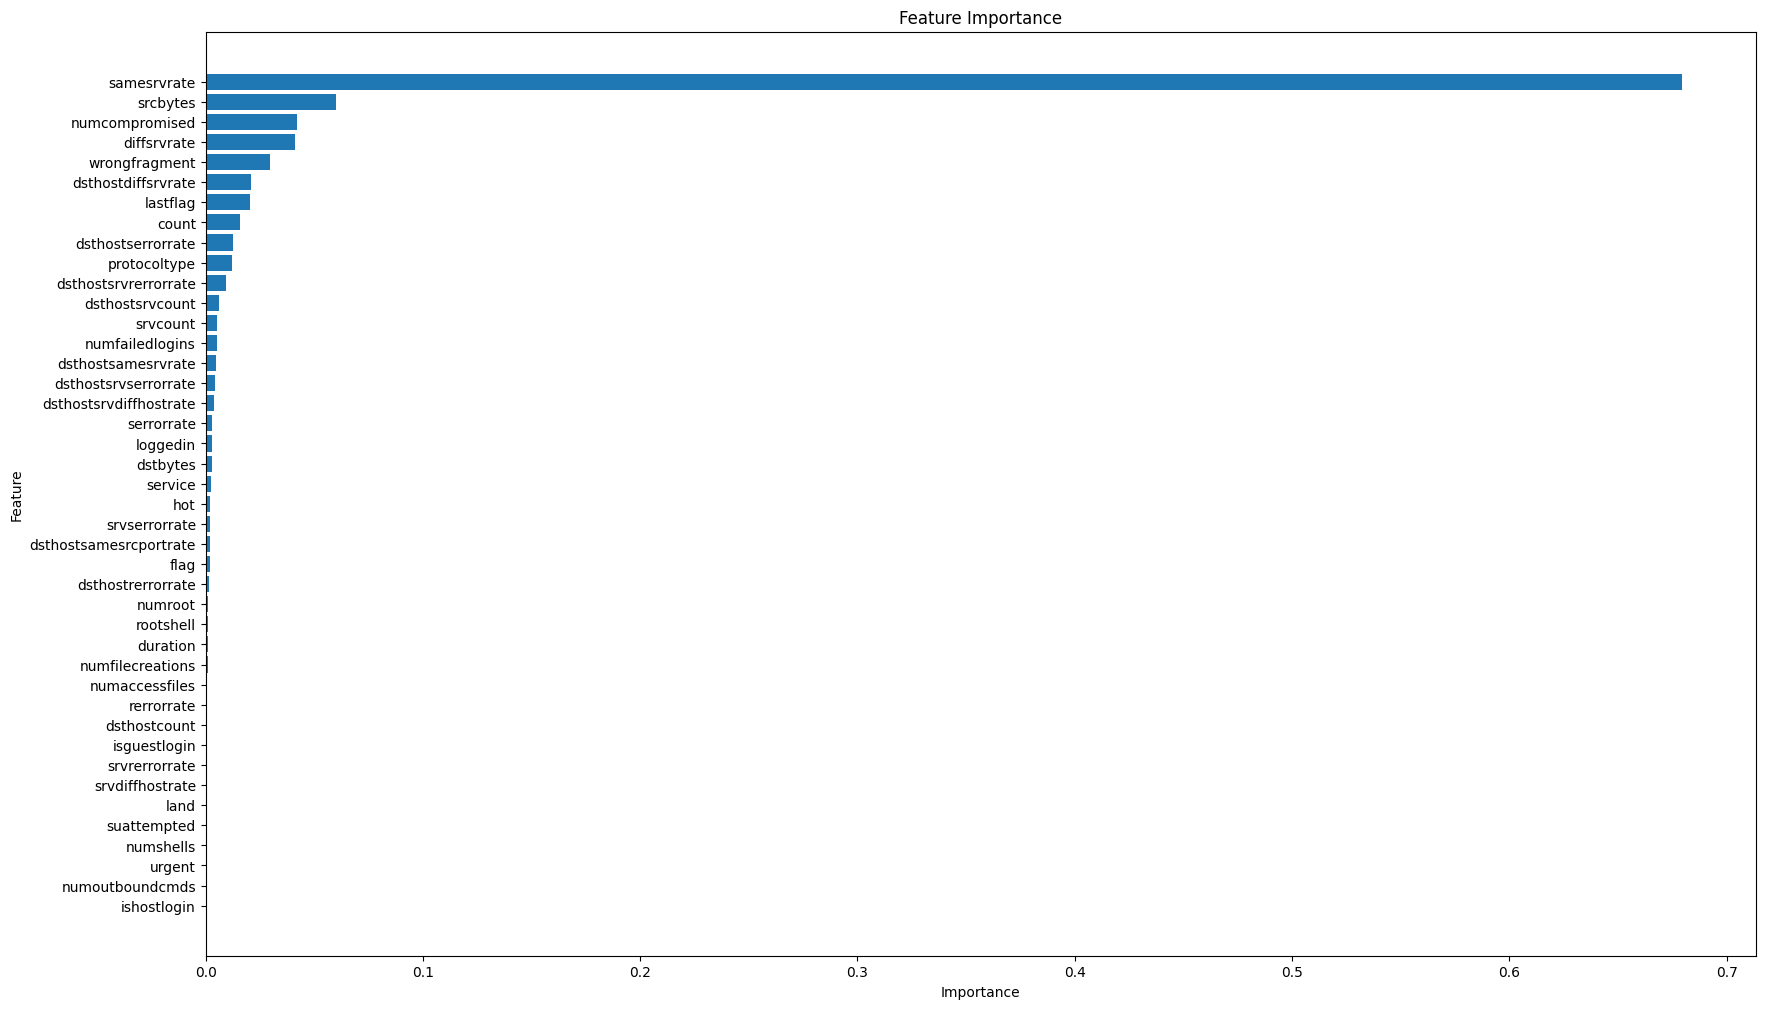

In [68]:
# Getting feature importance
feature_importances = xgb.feature_importances_

# Create a DataFrame
feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort features by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(20,12))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

#### Feature Reduction

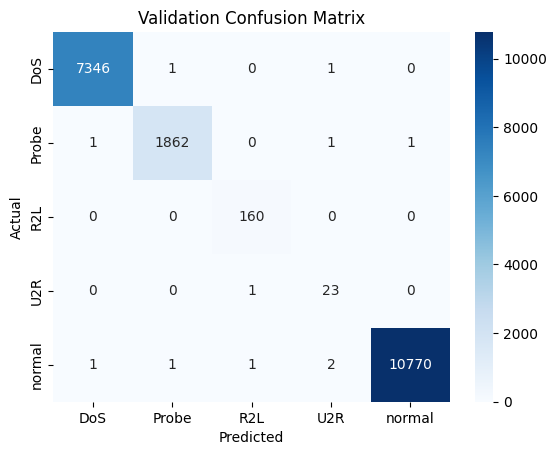

Validation Classification Report:
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      7348
       Probe       1.00      1.00      1.00      1865
         R2L       0.99      1.00      0.99       160
         U2R       0.85      0.96      0.90        24
      normal       1.00      1.00      1.00     10775

    accuracy                           1.00     20172
   macro avg       0.97      0.99      0.98     20172
weighted avg       1.00      1.00      1.00     20172



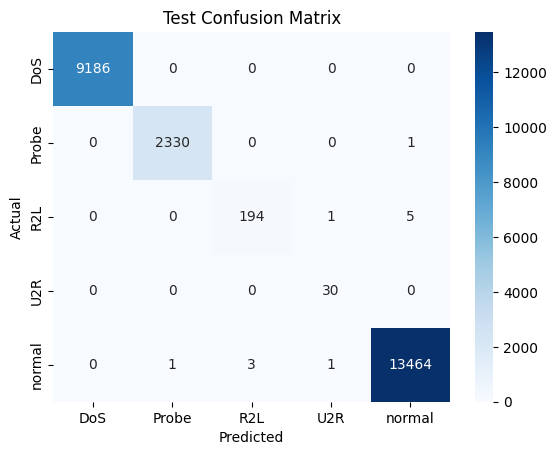

Test Classification Report:
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      9186
       Probe       1.00      1.00      1.00      2331
         R2L       0.98      0.97      0.98       200
         U2R       0.94      1.00      0.97        30
      normal       1.00      1.00      1.00     13469

    accuracy                           1.00     25216
   macro avg       0.98      0.99      0.99     25216
weighted avg       1.00      1.00      1.00     25216



2025/01/14 00:06:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [69]:
with mlflow.start_run():
    # Train the model
    xgb = XGBClassifier(n_estimators=250, max_depth=20, learning_rate=0.07, random_state=42)
    xgb.fit(X_train_red, y_train)
    
    # set tag
    mlflow.set_tag('mlflow.runName', 'xgb_n250_d20_l.07_red21')
        
    # Validation Data
    # Prediction
    y_pred_val = xgb.predict(X_val_red)
    
    # Accuracy
    val_acc = accuracy_score(y_val, y_pred_val)
    mlflow.log_metric("val_accuracy", val_acc)
    
    # Confusion Matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Validation Confusion Matrix')
    plt.savefig('val_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('val_confusion_matrix.png')
    
    # Classification Report
    y_val_transform = le.inverse_transform(y_val)
    y_pred_val_transform = le.inverse_transform(y_pred_val)
    classification_report_val = classification_report(y_val_transform, y_pred_val_transform)
    print('Validation Classification Report:\n', classification_report_val)
    
    with open('val_classification_report.txt', 'w') as f:
        f.write(classification_report_val)
    mlflow.log_artifact('val_classification_report.txt')
    
    # Test Data
    # Prediction
    y_pred = xgb.predict(X_test_red)
    
    # Accuracy
    test_acc = accuracy_score(y_test, y_pred)
    mlflow.log_metric("test_accuracy", test_acc)
    
    # Confusion Matrix
    cm_test = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test Confusion Matrix')
    plt.savefig('test_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('test_confusion_matrix.png')
    
    # Classification Report
    y_test_transform = le.inverse_transform(y_test)
    y_pred_transform = le.inverse_transform(y_pred)
    classification_report_test = classification_report(y_test_transform, y_pred_transform)
    print('Test Classification Report:\n', classification_report_test)
    
    with open('test_classification_report.txt', 'w') as f:
        f.write(classification_report_test)
    mlflow.log_artifact('test_classification_report.txt')
    
    # Log model
    mlflow.sklearn.log_model(xgb, "model")

    # Log parameters
    mlflow.log_param("n_estimators", xgb.n_estimators)
    mlflow.log_param("max_depth", xgb.max_depth)
    mlflow.log_param("learning_rate", xgb.learning_rate)
    mlflow.log_param("random_state", xgb.random_state)

#### AdaBoost

C:\Users\DEBDUT\anaconda3\envs\ipl\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


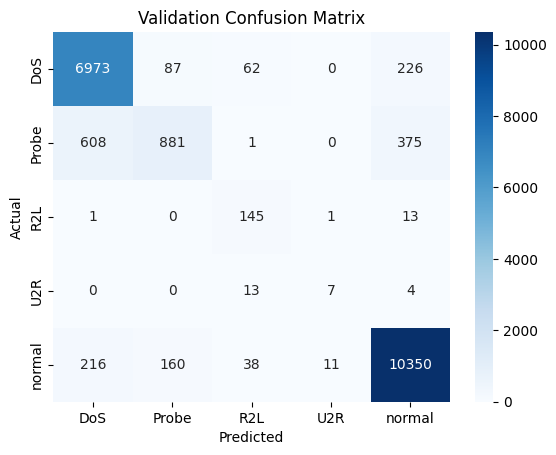

Validation Classification Report:
               precision    recall  f1-score   support

         DoS       0.89      0.95      0.92      7348
       Probe       0.78      0.47      0.59      1865
         R2L       0.56      0.91      0.69       160
         U2R       0.37      0.29      0.33        24
      normal       0.94      0.96      0.95     10775

    accuracy                           0.91     20172
   macro avg       0.71      0.72      0.70     20172
weighted avg       0.91      0.91      0.90     20172



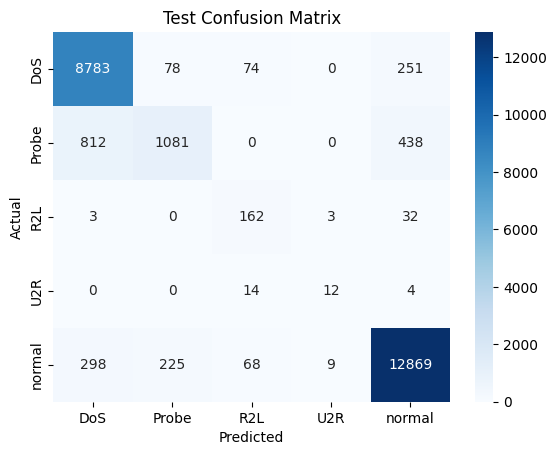

Test Classification Report:
               precision    recall  f1-score   support

         DoS       0.89      0.96      0.92      9186
       Probe       0.78      0.46      0.58      2331
         R2L       0.51      0.81      0.63       200
         U2R       0.50      0.40      0.44        30
      normal       0.95      0.96      0.95     13469

    accuracy                           0.91     25216
   macro avg       0.72      0.72      0.70     25216
weighted avg       0.91      0.91      0.90     25216



2025/01/14 00:06:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [70]:
with mlflow.start_run():
    # Train the model
    adb = AdaBoostClassifier(random_state=42)
    adb.fit(X_train, y_train)
    
    # set tag
    mlflow.set_tag('mlflow.runName', 'adb')
    
    # Validation Data
    # Prediction
    y_pred_val = adb.predict(X_val)
    
    # Accuracy
    val_acc = accuracy_score(y_val, y_pred_val)
    mlflow.log_metric("val_accuracy", val_acc)
    
    # Confusion Matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Validation Confusion Matrix')
    plt.savefig('val_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('val_confusion_matrix.png')
    
    # Classification Report
    y_val_transform = le.inverse_transform(y_val)
    y_pred_val_transform = le.inverse_transform(y_pred_val)
    classification_report_val = classification_report(y_val_transform, y_pred_val_transform)
    print('Validation Classification Report:\n', classification_report_val)
    
    with open('val_classification_report.txt', 'w') as f:
        f.write(classification_report_val)
    mlflow.log_artifact('val_classification_report.txt')
    
    # Test Data
    # Prediction
    y_pred = adb.predict(X_test)
    
    # Accuracy
    test_acc = accuracy_score(y_test, y_pred)
    mlflow.log_metric("test_accuracy", test_acc)
    
    # Confusion Matrix
    cm_test = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test Confusion Matrix')
    plt.savefig('test_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('test_confusion_matrix.png')
    
    # Classification Report
    y_test_transform = le.inverse_transform(y_test)
    y_pred_transform = le.inverse_transform(y_pred)
    classification_report_test = classification_report(y_test_transform, y_pred_transform)
    print('Test Classification Report:\n', classification_report_test)
    
    with open('test_classification_report.txt', 'w') as f:
        f.write(classification_report_test)
    mlflow.log_artifact('test_classification_report.txt')
    
    # Log model
    mlflow.sklearn.log_model(adb, "model")

    # Log parameters
    mlflow.log_param("n_estimators", adb.n_estimators)
    mlflow.log_param("random_state", adb.random_state)

#### LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3157
[LightGBM] [Info] Number of data points in the train set: 80688, number of used features: 38
[LightGBM] [Info] Start training from score -1.009833
[LightGBM] [Info] Start training from score -2.381034
[LightGBM] [Info] Start training from score -4.836877
[LightGBM] [Info] Start training from score -6.733997
[LightGBM] [Info] Start training from score -0.627090
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


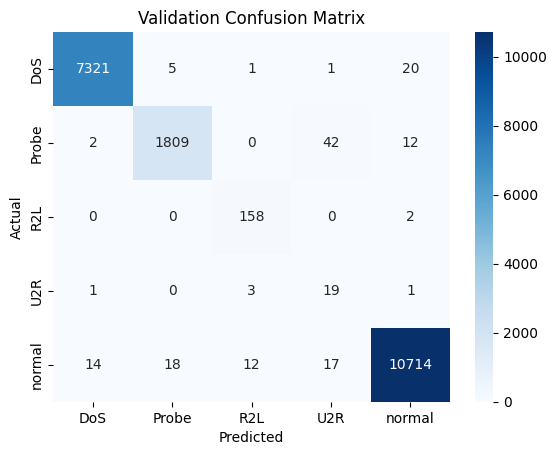

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7348
           1       0.99      0.97      0.98      1865
           2       0.91      0.99      0.95       160
           3       0.24      0.79      0.37        24
           4       1.00      0.99      1.00     10775

    accuracy                           0.99     20172
   macro avg       0.83      0.95      0.86     20172
weighted avg       0.99      0.99      0.99     20172



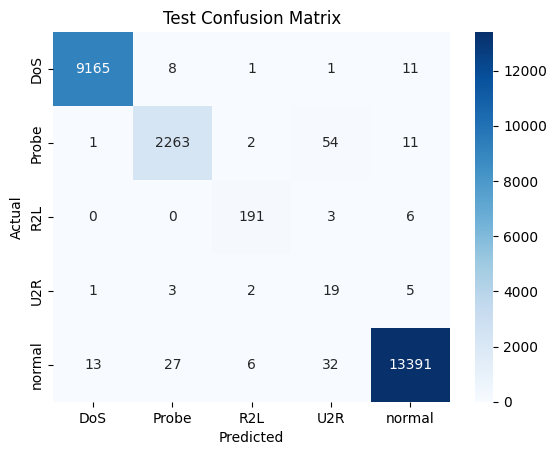

Test Classification Report:
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      9186
       Probe       0.98      0.97      0.98      2331
         R2L       0.95      0.95      0.95       200
         U2R       0.17      0.63      0.27        30
      normal       1.00      0.99      1.00     13469

    accuracy                           0.99     25216
   macro avg       0.82      0.91      0.84     25216
weighted avg       1.00      0.99      0.99     25216



2025/01/14 00:06:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [71]:
with mlflow.start_run():
    lgbm = lightgbm.LGBMClassifier(n_estimators=50, max_depth=10, random_state=42)
    lgbm.fit(X_train, y_train)

    # Validation Data
    # Prediction
    y_pred_val = lgbm.predict(X_val)

    # Set tag
    mlflow.set_tag('mlflow.runName', 'lgbm_50_d10')

    # Accuracy
    val_acc = accuracy_score(y_val, y_pred_val)
    mlflow.log_metric("val_accuracy", val_acc)

    # Confusion Matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Validation Confusion Matrix')
    plt.savefig('val_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('val_confusion_matrix.png')

    # Classification Report
    classification_report_val = classification_report(y_val, y_pred_val)
    print('Validation Classification Report:\n', classification_report_val)

    with open('val_classification_report.txt', 'w') as f:
        f.write(classification_report_val)
    mlflow.log_artifact('val_classification_report.txt')

    # Test Data
    # Prediction
    y_pred = lgbm.predict(X_test)

    # Accuracy
    test_acc = accuracy_score(y_test, y_pred)
    mlflow.log_metric("test_accuracy", test_acc)

    # Confusion Matrix
    cm_test = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test Confusion Matrix')
    plt.savefig('test_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('test_confusion_matrix.png')

    # Classification Report
    y_test_transform = le.inverse_transform(y_test)
    y_pred_transform = le.inverse_transform(y_pred)
    classification_report_test = classification_report(y_test_transform, y_pred_transform)
    print('Test Classification Report:\n', classification_report_test)

    with open('test_classification_report.txt', 'w') as f:
        f.write(classification_report_test)
    mlflow.log_artifact('test_classification_report.txt')

    # Log model
    mlflow.sklearn.log_model(lgbm, "model")
    
    # Log parameters
    mlflow.log_param("n_estimators", lgbm.n_estimators)
    mlflow.log_param("max_depth", lgbm.max_depth)
    mlflow.log_param("learning_rate", lgbm.learning_rate)
    mlflow.log_param("random_state", lgbm.random_state)

#### Voting Classifier

Without Feature Reduction

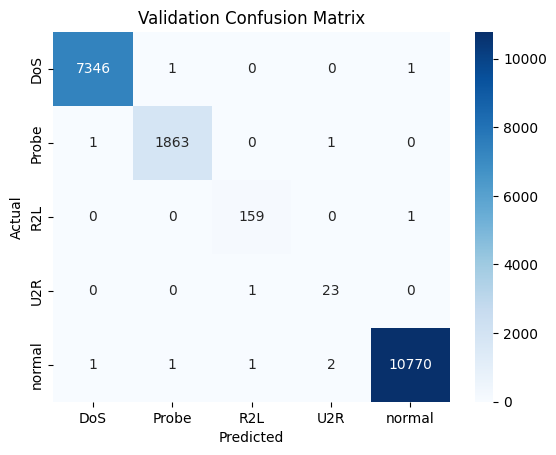

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7348
           1       1.00      1.00      1.00      1865
           2       0.99      0.99      0.99       160
           3       0.88      0.96      0.92        24
           4       1.00      1.00      1.00     10775

    accuracy                           1.00     20172
   macro avg       0.97      0.99      0.98     20172
weighted avg       1.00      1.00      1.00     20172



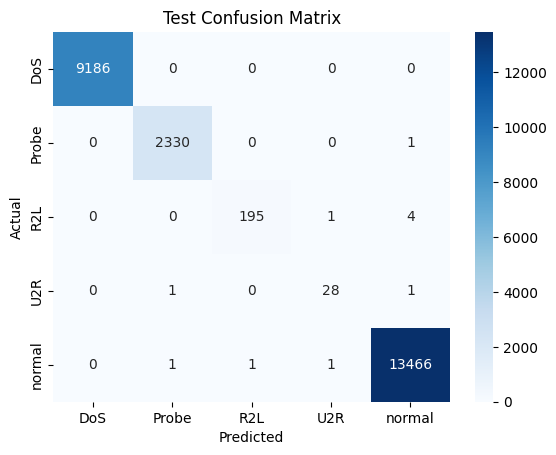

Test Classification Report:
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      9186
       Probe       1.00      1.00      1.00      2331
         R2L       0.99      0.97      0.98       200
         U2R       0.93      0.93      0.93        30
      normal       1.00      1.00      1.00     13469

    accuracy                           1.00     25216
   macro avg       0.99      0.98      0.98     25216
weighted avg       1.00      1.00      1.00     25216



2025/01/14 00:07:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [72]:
with mlflow.start_run():
    
    # Create a Voting Classifier
    voting_clf = VotingClassifier(estimators=[('rfc', rfc), ('xgb', xgb)], voting='soft', weights=(2,1))

    # Train the Voting Classifier
    voting_clf.fit(X_train, y_train)
    
    # Set tag
    mlflow.set_tag('mlflow.runName', 'vc_soft_w21')

    # Validation Data
    # Prediction
    y_pred_val = voting_clf.predict(X_val)

    # Accuracy
    val_acc = accuracy_score(y_val, y_pred_val)
    mlflow.log_metric("val_accuracy", val_acc)

    # Confusion Matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Validation Confusion Matrix')
    plt.savefig('val_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('val_confusion_matrix.png')

    # Classification Report
    classification_report_val = classification_report(y_val, y_pred_val)
    print('Validation Classification Report:\n', classification_report_val)

    with open('val_classification_report.txt', 'w') as f:
        f.write(classification_report_val)
    mlflow.log_artifact('val_classification_report.txt')

    # Test Data
    # Prediction
    y_pred = voting_clf.predict(X_test)

    # Accuracy
    test_acc = accuracy_score(y_test, y_pred)
    mlflow.log_metric("test_accuracy", test_acc)

    # Confusion Matrix
    cm_test = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test Confusion Matrix')
    plt.savefig('test_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('test_confusion_matrix.png')

    # Classification Report
    y_test_transform = le.inverse_transform(y_test)
    y_pred_transform = le.inverse_transform(y_pred)
    classification_report_test = classification_report(y_test_transform, y_pred_transform)
    print('Test Classification Report:\n', classification_report_test)

    with open('test_classification_report.txt', 'w') as f:
        f.write(classification_report_test)
    mlflow.log_artifact('test_classification_report.txt')

    # Log parameters
    mlflow.log_param("voting", voting_clf.voting)

    # Log model
    mlflow.sklearn.log_model(voting_clf, "model")

With Feature Reduction

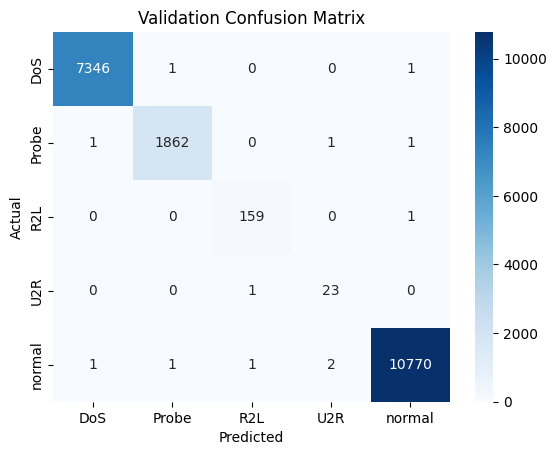

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7348
           1       1.00      1.00      1.00      1865
           2       0.99      0.99      0.99       160
           3       0.88      0.96      0.92        24
           4       1.00      1.00      1.00     10775

    accuracy                           1.00     20172
   macro avg       0.97      0.99      0.98     20172
weighted avg       1.00      1.00      1.00     20172



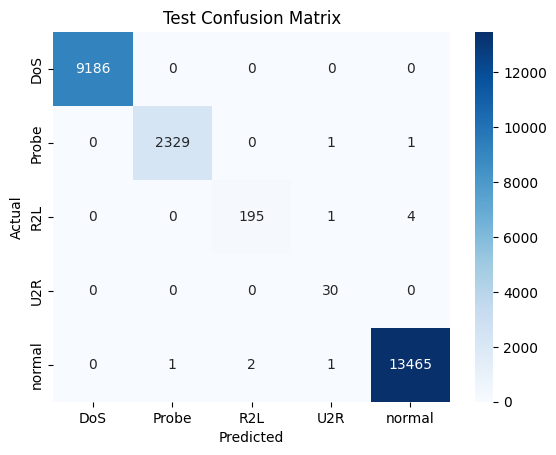

Test Classification Report:
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      9186
       Probe       1.00      1.00      1.00      2331
         R2L       0.99      0.97      0.98       200
         U2R       0.91      1.00      0.95        30
      normal       1.00      1.00      1.00     13469

    accuracy                           1.00     25216
   macro avg       0.98      0.99      0.99     25216
weighted avg       1.00      1.00      1.00     25216



2025/01/14 00:08:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [73]:
with mlflow.start_run():
    
    # Create a Voting Classifier
    voting_clf = VotingClassifier(estimators=[('rfc', rfc), ('xgb', xgb)], voting='soft', weights=(2,1))

    # Train the Voting Classifier
    voting_clf.fit(X_train_red, y_train)
    
    # Set tag
    mlflow.set_tag('mlflow.runName', 'vc_soft_red21_w21')

    # Validation Data
    # Prediction
    y_pred_val = voting_clf.predict(X_val_red)

    # Accuracy
    val_acc = accuracy_score(y_val, y_pred_val)
    mlflow.log_metric("val_accuracy", val_acc)

    # Confusion Matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Validation Confusion Matrix')
    plt.savefig('val_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('val_confusion_matrix.png')

    # Classification Report
    classification_report_val = classification_report(y_val, y_pred_val)
    print('Validation Classification Report:\n', classification_report_val)

    with open('val_classification_report.txt', 'w') as f:
        f.write(classification_report_val)
    mlflow.log_artifact('val_classification_report.txt')

    # Test Data
    # Prediction
    y_pred = voting_clf.predict(X_test_red)

    # Accuracy
    test_acc = accuracy_score(y_test, y_pred)
    mlflow.log_metric("test_accuracy", test_acc)

    # Confusion Matrix
    cm_test = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test Confusion Matrix')
    plt.savefig('test_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('test_confusion_matrix.png')

    # Classification Report
    y_test_transform = le.inverse_transform(y_test)
    y_pred_transform = le.inverse_transform(y_pred)
    classification_report_test = classification_report(y_test_transform, y_pred_transform)
    print('Test Classification Report:\n', classification_report_test)

    with open('test_classification_report.txt', 'w') as f:
        f.write(classification_report_test)
    mlflow.log_artifact('test_classification_report.txt')

    # Log parameters
    mlflow.log_param("voting", voting_clf.voting)

    # Log model
    mlflow.sklearn.log_model(voting_clf, "model")

#### Probabilities of the Prediction

In [74]:
# Create test dataframe
y_test_df = pd.DataFrame(y_test_transform, columns=['y_test'])
y_pred_df = pd.DataFrame(y_pred_transform, columns=['y_pred'])

# Concatenate X_test, y_test_df, and y_pred_df
df_test = pd.concat([pd.DataFrame(X_test_red).reset_index(drop=True), y_test_df.reset_index(drop=True), y_pred_df.reset_index(drop=True)], axis=1)

In [75]:
# Predict probabilities
df_test['prob_DoS'] = voting_clf.predict_proba(X_test_red)[:, 0]
df_test['prob_Probe'] = voting_clf.predict_proba(X_test_red)[:, 1]
df_test['prob_R2L'] = voting_clf.predict_proba(X_test_red)[:, 2]
df_test['prob_U2R'] = voting_clf.predict_proba(X_test_red)[:, 3]
df_test['prob_normal'] = voting_clf.predict_proba(X_test_red)[:, 4]

In [76]:
def prob_outcome(row, probas):
    y_pred = row['y_pred']
    row_index = row.name  # Get the row index to fetch the correct probability
    if y_pred == 'DoS':
        return probas[row_index, 0]
    elif y_pred == 'Probe':
        return probas[row_index, 1]
    elif y_pred == 'R2L':
        return probas[row_index, 2]
    elif y_pred == 'U2R':
        return probas[row_index, 3]
    else:
        return probas[row_index, 4]

probas = voting_clf.predict_proba(X_test_red)
df_test['prob_outcome'] = df_test.apply(lambda row: prob_outcome(row, probas), axis=1)

In [77]:
df_test.head()

,protocoltype,service,flag,srcbytes,dstbytes,loggedin,count,srvcount,serrorrate,srvserrorrate,...,dsthostsrvserrorrate,lastflag,y_test,y_pred,prob_DoS,prob_Probe,prob_R2L,prob_U2R,prob_normal,prob_outcome
0,-0.124687,-0.442556,0.750636,-0.007730,-0.002794,1.234706,-0.603060,-0.175129,-0.636891,-0.631568,...,-0.624524,0.646765,normal,normal,6.059584e-07,2.804940e-07,4.079397e-07,3.433959e-07,0.999998,0.999998
1,-0.124687,0.780564,-2.224591,-0.007766,-0.004919,-0.809909,3.275176,-0.367940,-0.457657,-0.631568,...,-0.624524,-0.639948,Probe,Probe,1.088644e-05,9.999843e-01,8.188338e-07,7.581821e-07,0.000003,0.999984
2,-0.124687,1.086343,-0.736978,-0.007766,-0.004919,-0.809909,0.305355,-0.120040,1.603534,1.606014,...,1.619867,-0.639948,DoS,DoS,9.999977e-01,8.228703e-07,2.693744e-07,2.029840e-07,0.000001,0.999998
3,2.220183,0.780564,0.750636,-0.007741,-0.004893,-0.809909,-0.716612,-0.354168,-0.636891,-0.631568,...,-0.624524,0.646765,normal,normal,8.359159e-07,2.913988e-06,5.594594e-07,3.656603e-07,0.999995,0.999995
4,-0.124687,-0.442556,0.750636,-0.007709,-0.004726,1.234706,-0.629265,0.114088,-0.636891,-0.631568,...,-0.624524,0.646765,normal,normal,5.861233e-07,3.259540e-07,2.954353e-07,3.578683e-07,0.999998,0.999998


In [78]:
df_test[df_test['y_test']!=df_test['y_pred']]

,protocoltype,service,flag,srcbytes,dstbytes,loggedin,count,srvcount,serrorrate,srvserrorrate,...,dsthostsrvserrorrate,lastflag,y_test,y_pred,prob_DoS,prob_Probe,prob_R2L,prob_U2R,prob_normal,prob_outcome
2920,-0.124687,1.086343,-2.224591,-0.007766,-0.004919,-0.809909,-0.725347,-0.367940,-0.636891,-0.631568,...,-0.624524,-4.500085,normal,Probe,0.013459,0.687377,0.010188,0.000594,0.288382,0.687377
6750,-0.124687,-0.748335,0.750636,-0.007588,-0.004152,1.234706,-0.725347,-0.367940,-0.636891,-0.631568,...,-0.624524,-1.926660,normal,R2L,0.012642,0.015137,0.516088,0.001400,0.454733,0.516088
8111,-0.124687,1.392123,0.750636,-0.007549,-0.004785,1.234706,-0.725347,-0.367940,-0.636891,-0.631568,...,-0.624524,-6.644606,Probe,U2R,0.005904,0.327303,0.149527,0.375017,0.142249,0.375017
8827,-0.124687,-0.687179,0.750636,-0.007465,-0.004919,1.234706,-0.725347,-0.367940,-0.636891,-0.631568,...,-0.624524,-3.642277,normal,R2L,0.000113,0.000047,0.819619,0.000085,0.180137,0.819619
10225,-0.124687,1.086343,-1.480785,-0.007766,-0.004919,-0.809909,-0.716612,-0.354168,0.483321,0.487223,...,0.497671,0.217861,Probe,normal,0.127818,0.312318,0.006938,0.000426,0.552500,0.552500
14461,-0.124687,-0.687179,0.750636,-0.007766,-0.003444,1.234706,-0.725347,-0.367940,-0.636891,-0.631568,...,-0.624524,-3.642277,normal,U2R,0.000073,0.003551,0.018696,0.805626,0.172054,0.805626
17842,-0.124687,1.759059,-1.852688,-0.007745,-0.004874,-0.809909,-0.716612,-0.354168,0.483321,0.487223,...,0.497671,-0.211043,R2L,normal,0.035054,0.023363,0.240118,0.006685,0.694780,0.694780
21568,-0.124687,1.759059,0.378732,-0.007745,-0.004874,-0.809909,-0.725347,-0.367940,1.603534,1.606014,...,1.619867,-1.068852,R2L,normal,0.072016,0.013782,0.096964,0.013455,0.803783,0.803783
21719,-0.124687,-0.687179,0.750636,-0.007766,-0.004708,-0.809909,-0.716612,-0.354168,-0.636891,-0.631568,...,-0.624524,-2.784469,R2L,U2R,0.016891,0.050549,0.166784,0.596459,0.169316,0.596459
22241,-0.124687,1.759059,0.378732,-0.007745,-0.004874,-0.809909,-0.716612,-0.354168,0.483321,0.487223,...,-0.422529,-1.926660,R2L,normal,0.010074,0.000033,0.170215,0.010013,0.809665,0.809665


## Final Model Building

#### Standardization of data - 21 features

In [79]:
cols = df_red['Feature'].tolist()

In [81]:
X_red = X.drop(cols, axis=1)

col = X_red.columns

scaler = StandardScaler()
X_std = scaler.fit_transform(X_red)
X_std = pd.DataFrame(X_std, columns=col)

In [82]:
X_std.head()

,protocoltype,service,flag,srcbytes,dstbytes,loggedin,count,srvcount,serrorrate,srvserrorrate,...,diffsrvrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,lastflag
0,-0.124687,-0.687179,0.750636,-0.007682,-0.004919,-0.809909,-0.716612,-0.354168,-0.636891,-0.631568,...,-0.349714,-0.322807,-0.818197,-0.782858,-0.280121,0.068861,-0.289239,-0.639168,-0.624524,0.217861
1,2.220183,0.780564,0.750636,-0.007741,-0.004919,-0.809909,-0.620530,-0.367940,-0.636891,-0.631568,...,0.482049,0.734957,-1.035007,-1.161531,2.737767,2.364522,-0.289239,-0.639168,-0.624524,-1.926660
2,-0.124687,1.086343,-0.736978,-0.007766,-0.004919,-0.809909,0.340294,-0.299079,1.603534,1.606014,...,0.038442,0.734957,-0.809163,-0.938782,-0.174231,-0.480804,-0.289239,1.609670,1.619867,-0.211043
3,-0.124687,-0.442556,0.750636,-0.007727,-0.002890,1.234706,-0.690408,-0.312852,-0.188806,-0.184051,...,-0.349714,-1.531680,1.259559,1.065962,-0.438958,-0.383804,0.065732,-0.571703,-0.602080,0.646765
4,-0.124687,-0.442556,0.750636,-0.007732,-0.004814,1.234706,-0.472039,0.058999,-0.636891,-0.631568,...,-0.349714,0.734957,1.259559,1.065962,-0.438958,-0.480804,-0.289239,-0.639168,-0.624524,0.646765


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

#### Random Forest Classifier

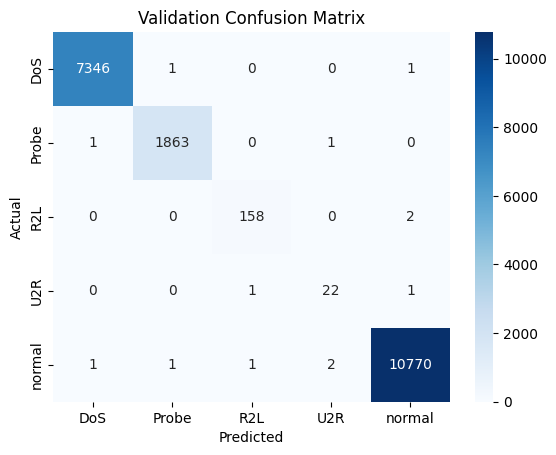

Validation Classification Report:
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      7348
       Probe       1.00      1.00      1.00      1865
         R2L       0.99      0.99      0.99       160
         U2R       0.88      0.92      0.90        24
      normal       1.00      1.00      1.00     10775

    accuracy                           1.00     20172
   macro avg       0.97      0.98      0.98     20172
weighted avg       1.00      1.00      1.00     20172



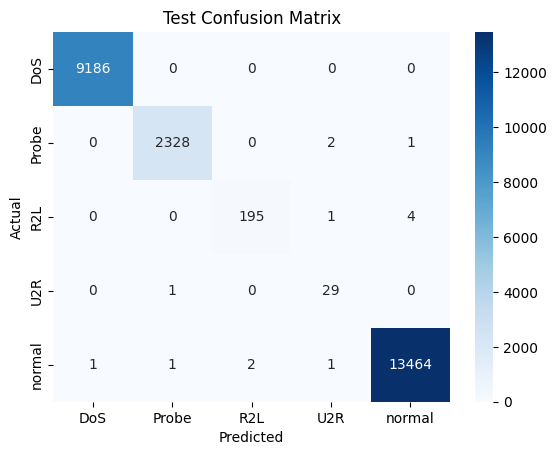

Test Classification Report:
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      9186
       Probe       1.00      1.00      1.00      2331
         R2L       0.99      0.97      0.98       200
         U2R       0.88      0.97      0.92        30
      normal       1.00      1.00      1.00     13469

    accuracy                           1.00     25216
   macro avg       0.97      0.99      0.98     25216
weighted avg       1.00      1.00      1.00     25216



2025/01/14 03:11:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [85]:
with mlflow.start_run():
    # Train the model
    rfc = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
    rfc.fit(X_train, y_train)
    
    # set tag
    mlflow.set_tag('mlflow.runName', 'rf_red_200_d20_red21')
    
    # Validation Data
    # Prediction
    y_pred_val = rfc.predict(X_val)
    
    # Accuracy
    val_acc = accuracy_score(y_val, y_pred_val)
    mlflow.log_metric("val_accuracy", val_acc)
    
    # Confusion Matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Validation Confusion Matrix')
    plt.savefig('val_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('val_confusion_matrix.png')
    
    # Classification Report
    y_val_transform = le.inverse_transform(y_val)
    y_pred_val_transform = le.inverse_transform(y_pred_val)
    classification_report_val = classification_report(y_val_transform, y_pred_val_transform)
    print('Validation Classification Report:\n', classification_report_val)
    
    with open('val_classification_report.txt', 'w') as f:
        f.write(classification_report_val)
    mlflow.log_artifact('val_classification_report.txt')
    
    # Test Data
    # Prediction
    y_pred = rfc.predict(X_test)
    
    # Accuracy
    test_acc = accuracy_score(y_test, y_pred)
    mlflow.log_metric("test_accuracy", test_acc)
    
    # Confusion Matrix
    cm_test = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test Confusion Matrix')
    plt.savefig('test_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('test_confusion_matrix.png')
    
    # Classification Report
    y_test_transform = le.inverse_transform(y_test)
    y_pred_transform = le.inverse_transform(y_pred)
    classification_report_test = classification_report(y_test_transform, y_pred_transform)
    print('Test Classification Report:\n', classification_report_test)
    
    with open('test_classification_report.txt', 'w') as f:
        f.write(classification_report_test)
    mlflow.log_artifact('test_classification_report.txt')
    
    # Log model
    mlflow.sklearn.log_model(rfc, "model")

    # Log parameters
    mlflow.log_param("n_estimators", rfc.n_estimators)
    mlflow.log_param("max_depth", rfc.max_depth)
    mlflow.log_param("random_state", rfc.random_state)

#### XGBoost

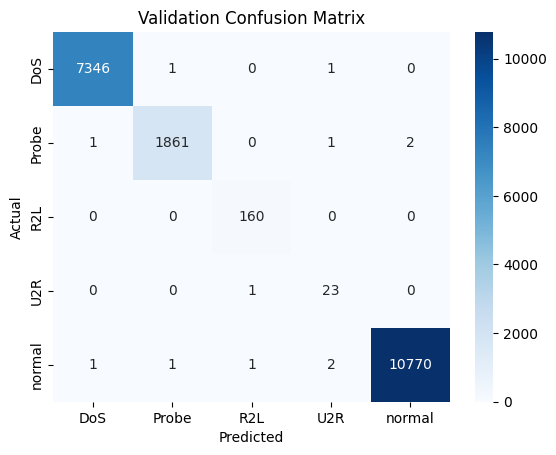

Validation Classification Report:
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      7348
       Probe       1.00      1.00      1.00      1865
         R2L       0.99      1.00      0.99       160
         U2R       0.85      0.96      0.90        24
      normal       1.00      1.00      1.00     10775

    accuracy                           1.00     20172
   macro avg       0.97      0.99      0.98     20172
weighted avg       1.00      1.00      1.00     20172



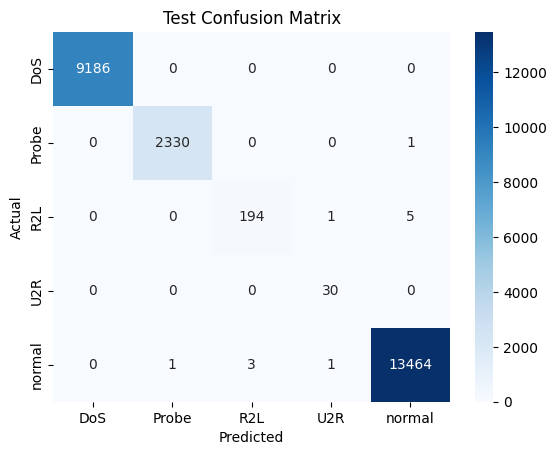

Test Classification Report:
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      9186
       Probe       1.00      1.00      1.00      2331
         R2L       0.98      0.97      0.98       200
         U2R       0.94      1.00      0.97        30
      normal       1.00      1.00      1.00     13469

    accuracy                           1.00     25216
   macro avg       0.98      0.99      0.99     25216
weighted avg       1.00      1.00      1.00     25216



2025/01/14 03:12:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [86]:
with mlflow.start_run():
    # Train the model
    xgb = XGBClassifier(n_estimators=250, max_depth=20, learning_rate=0.06, random_state=42)
    xgb.fit(X_train, y_train)
    
    # set tag
    mlflow.set_tag('mlflow.runName', 'xgb_n250_d20_l.06_red21')
        
    # Validation Data
    # Prediction
    y_pred_val = xgb.predict(X_val)
    
    # Accuracy
    val_acc = accuracy_score(y_val, y_pred_val)
    mlflow.log_metric("val_accuracy", val_acc)
    
    # Confusion Matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Validation Confusion Matrix')
    plt.savefig('val_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('val_confusion_matrix.png')
    
    # Classification Report
    y_val_transform = le.inverse_transform(y_val)
    y_pred_val_transform = le.inverse_transform(y_pred_val)
    classification_report_val = classification_report(y_val_transform, y_pred_val_transform)
    print('Validation Classification Report:\n', classification_report_val)
    
    with open('val_classification_report.txt', 'w') as f:
        f.write(classification_report_val)
    mlflow.log_artifact('val_classification_report.txt')
    
    # Test Data
    # Prediction
    y_pred = xgb.predict(X_test)
    
    # Accuracy
    test_acc = accuracy_score(y_test, y_pred)
    mlflow.log_metric("test_accuracy", test_acc)
    
    # Confusion Matrix
    cm_test = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test Confusion Matrix')
    plt.savefig('test_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('test_confusion_matrix.png')
    
    # Classification Report
    y_test_transform = le.inverse_transform(y_test)
    y_pred_transform = le.inverse_transform(y_pred)
    classification_report_test = classification_report(y_test_transform, y_pred_transform)
    print('Test Classification Report:\n', classification_report_test)
    
    with open('test_classification_report.txt', 'w') as f:
        f.write(classification_report_test)
    mlflow.log_artifact('test_classification_report.txt')
    
    # Log model
    mlflow.sklearn.log_model(xgb, "model")

    # Log parameters
    mlflow.log_param("n_estimators", xgb.n_estimators)
    mlflow.log_param("max_depth", xgb.max_depth)
    mlflow.log_param("learning_rate", xgb.learning_rate)
    mlflow.log_param("random_state", xgb.random_state)

#### Voting Classifier

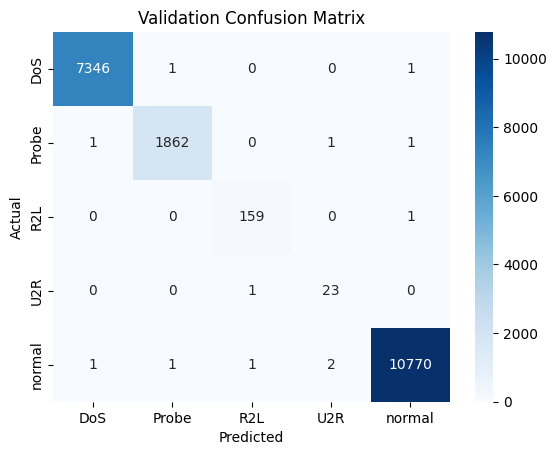

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7348
           1       1.00      1.00      1.00      1865
           2       0.99      0.99      0.99       160
           3       0.88      0.96      0.92        24
           4       1.00      1.00      1.00     10775

    accuracy                           1.00     20172
   macro avg       0.97      0.99      0.98     20172
weighted avg       1.00      1.00      1.00     20172



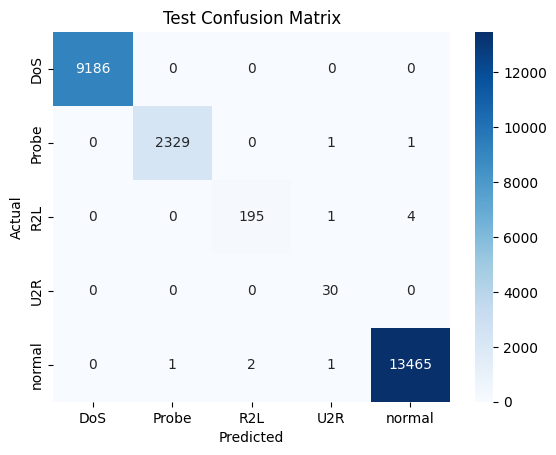

Test Classification Report:
               precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      9186
       Probe       1.00      1.00      1.00      2331
         R2L       0.99      0.97      0.98       200
         U2R       0.91      1.00      0.95        30
      normal       1.00      1.00      1.00     13469

    accuracy                           1.00     25216
   macro avg       0.98      0.99      0.99     25216
weighted avg       1.00      1.00      1.00     25216



2025/01/14 03:13:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [87]:
with mlflow.start_run():
    
    # Create a Voting Classifier
    voting_clf = VotingClassifier(estimators=[('rfc', rfc), ('xgb', xgb)], voting='soft', weights=(2,1))

    # Train the Voting Classifier
    voting_clf.fit(X_train, y_train)
    
    # Set tag
    mlflow.set_tag('mlflow.runName', 'vc_soft_red21_w21')

    # Validation Data
    # Prediction
    y_pred_val = voting_clf.predict(X_val)

    # Accuracy
    val_acc = accuracy_score(y_val, y_pred_val)
    mlflow.log_metric("val_accuracy", val_acc)

    # Confusion Matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Validation Confusion Matrix')
    plt.savefig('val_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('val_confusion_matrix.png')

    # Classification Report
    classification_report_val = classification_report(y_val, y_pred_val)
    print('Validation Classification Report:\n', classification_report_val)

    with open('val_classification_report.txt', 'w') as f:
        f.write(classification_report_val)
    mlflow.log_artifact('val_classification_report.txt')

    # Test Data
    # Prediction
    y_pred = voting_clf.predict(X_test)

    # Accuracy
    test_acc = accuracy_score(y_test, y_pred)
    mlflow.log_metric("test_accuracy", test_acc)

    # Confusion Matrix
    cm_test = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test Confusion Matrix')
    plt.savefig('test_confusion_matrix.png')
    plt.show()
    mlflow.log_artifact('test_confusion_matrix.png')

    # Classification Report
    y_test_transform = le.inverse_transform(y_test)
    y_pred_transform = le.inverse_transform(y_pred)
    classification_report_test = classification_report(y_test_transform, y_pred_transform)
    print('Test Classification Report:\n', classification_report_test)

    with open('test_classification_report.txt', 'w') as f:
        f.write(classification_report_test)
    mlflow.log_artifact('test_classification_report.txt')

    # Log parameters
    mlflow.log_param("voting", voting_clf.voting)

    # Log model
    mlflow.sklearn.log_model(voting_clf, "model")

### Pickle

In [93]:
model_path = 'model\model.pkl'

# Save the model
with open(model_path, 'wb') as f:
    pickle.dump((voting_clf, scaler), f)